## Connectome KDE plot - all behavior

In [3]:
using Revise

In [4]:
using NeuroPALData, DelimitedFiles, ANTSUNData, HDF5, JSON, PyPlot,
    PyCall, Statistics, Combinatorics, LinearAlgebra, FlavellBase, NaNMath,
    Distances, StatsBase, Random, Suppressor, LinearAlgebra, ProgressMeter,
    FlavellConstants, EncoderModelGen, HypothesisTests,
    CePNEMAnalysis, YAML, Clustering, JLD2, Distributions, MultipleTesting,
    KernelDensity, ConnectomePlot, Colors, HierarchicalPosteriorModel, GLM, DataFrames
zstd = FlavellBase.standardize

rc_params = PyDict(pyimport("matplotlib")["rcParams"]);
rc_params["font.sans-serif"] = ["Arial"];
rc_params["font.size"] = 7;
fix_plot() = (margins(0.05); tick_params(direction = "out");
    ax = gca(); ax[:xaxis][:tick_bottom]();
    ax[:yaxis][:tick_left]();
    ax[:spines]["top"]["set_visible"](false);
    ax[:spines]["right"]["set_visible"](false););

WebIO._IJuliaInit()

In [5]:
path_fig_root = "/data1/prj_kfc/figure/manuscript/cell_draft2/figure5/"
mkpath(path_fig_root)

"/data1/prj_kfc/figure/manuscript/cell_draft2/figure5"

In [6]:
py_scipy = pyimport("scipy")
py_nx = pyimport("networkx")
py_copy = pyimport("copy");

In [7]:
θh_pos_is_ventral = YAML.load_file("/data1/prj_kfc/data/data_constant/pos_is_ventral.yaml");

## Data

### Load data

In [8]:
list_uid_baseline = sort(["2022-06-14-01", "2022-06-14-07",
    "2022-06-14-13", "2022-06-28-01", "2022-06-28-07",
    "2022-07-15-06", "2022-07-15-12",
    "2022-07-20-01", "2022-07-26-01", "2022-08-02-01",
    "2023-01-09-28", "2023-01-17-01", "2023-01-19-01",
    "2023-01-19-08", "2023-01-19-15", "2023-01-19-22",
    "2023-01-23-01", "2023-01-23-08", "2023-01-23-15", "2023-01-23-21",
    "2023-03-07-01"])

list_uid_heat = ["2022-12-21-06", "2023-01-05-01", "2023-01-05-18",
    "2023-01-06-01", "2023-01-06-08", "2023-01-06-15", "2023-01-09-08",
    "2023-01-09-15", "2023-01-09-22", "2023-01-10-07", "2023-01-10-14",
    "2023-01-13-07", "2023-01-16-01", "2023-01-16-08", "2023-01-16-15",
    "2023-01-16-22", "2023-01-17-07", "2023-01-17-14", "2023-01-18-01"] |> sort;
# short: "2022-05-17-01", "2022-05-17-06"

In [9]:
list_uid = vcat(list_uid_baseline, list_uid_heat); length(list_uid)

40

In [10]:
list_data_dict = []
@showprogress for (idx_uid, data_uid) = enumerate(list_uid)
    path_data = "/scratch/prj_kfc/processed_h5/$(data_uid)-data.h5"
    data_dict = import_data(path_data, custom_keys=["neuropal_registration"])

    push!(list_data_dict, data_dict)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


### Load NeuroPAL

In [11]:
# list_neuropal_label = []
# for (idx_uid, data_uid) = enumerate(list_uid)
#     path_label = joinpath("/data1/prj_neuropal/data/neuropal_label_prj_kfc/", "$(data_uid) Neuron ID.xlsx")
#     # println(data_uid)
#     push!(list_neuropal_label, import_neuropal_label(path_label))
# end

In [12]:
list_neuropal_label = load("/scratch/prj_kfc/list_neuropal_label.jld2")["list_neuropal_label"];

In [13]:
# path_h5_enc = "/data1/prj_kfc/data/gen_analysis_data/2022-10-14-neuropal-enc.h5"
path_h5_enc = "/scratch/prj_kfc/2023-03-31-neuropal-baseline-enc.h5"
path_h5_enc_heat = "/scratch/prj_kfc/2023-03-07-neuropal-heatstim-enc.h5"
list_dict_fit = []

@showprogress for uid = list_uid
    if uid in list_uid_baseline
        push!(list_dict_fit, h5read(path_h5_enc, uid))
    elseif uid in list_uid_heat
        push!(list_dict_fit, h5read(path_h5_enc_heat, uid))        
    else
        error("$uid does not exist")
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:30


In [14]:
list_neuropal_order_info = readdlm("/data1/prj_neuropal/data/neuropal_label_prj_kfc/NeuroPAL order LR.csv",',');

In [15]:
list_class_dv = get_list_class_dv(map(x->x[1],list_neuropal_label));

In [16]:
list_class_ordered = generate_list_class_custom_order(list_neuropal_order_info, list_class_dv);

┌ Warning: class ASE is not in the orderling file
└ @ NeuroPALData ~/.julia/packages/NeuroPALData/P9Wwv/src/class.jl:100
┌ Warning: class IL1 is not in the orderling file
└ @ NeuroPALData ~/.julia/packages/NeuroPALData/P9Wwv/src/class.jl:100
┌ Warning: class IL2 is not in the orderling file
└ @ NeuroPALData ~/.julia/packages/NeuroPALData/P9Wwv/src/class.jl:100
┌ Warning: class RMH is not in the orderling file
└ @ NeuroPALData ~/.julia/packages/NeuroPALData/P9Wwv/src/class.jl:100
┌ Warning: class SAAD is not in the orderling file
└ @ NeuroPALData ~/.julia/packages/NeuroPALData/P9Wwv/src/class.jl:100
┌ Warning: class SABV is not in the orderling file
└ @ NeuroPALData ~/.julia/packages/NeuroPALData/P9Wwv/src/class.jl:100


In [17]:
list_class_classify_dv_enc = ["SIA","SMB"] # classify based on D/V tuning

2-element Vector{String}:
 "SIA"
 "SMB"

In [18]:
list_match_dict = get_list_match_dict(list_neuropal_label, list_data_dict=list_data_dict, list_dict_fit=list_dict_fit,
    list_class_ordered=list_class_ordered,
    list_class_classify_dv_enc=list_class_classify_dv_enc, θ_confidence_label=2.5);

In [19]:
list_uid_no_pumping = h5read(path_h5_enc, "list_uid_invalid_pt")
list_uid_pumping = setdiff(list_uid, list_uid_no_pumping)
list_idx_uid_pumping = [idx_uid for idx_uid = 1:length(list_uid) if list_uid[idx_uid] in list_uid_pumping];

In [20]:
list_class_dv_ordered = let
    list_all_class = unique(vcat(map(x->collect(keys(x[2])), list_match_dict)...))
    list_intersect = intersect(map(x->x[2], list_class_ordered), list_all_class)
    println("missing (in the ordering file but not in the matches): ", setdiff(setdiff(map(x->x[2], list_class_ordered), list_all_class)))
    println("n(class): $(length(list_intersect))")
    list_intersect
end;

missing (in the ordering file but not in the matches): Any["AVG", "RIG", "DB02", "DD01", "VB01", "ADF"]
n(class): 97


In [21]:
function get_list_use_rg_t(list_uid, list_uid_heat, list_dict_fit; θ_pumping=0.5)
    list_all = Tuple{String,Vector{Int}}[]
    list_pumping = Tuple{String,Vector{Int}}[]
    
    for (i_uid, uid) = enumerate(list_uid)
        lattice_range_p = list_dict_fit[i_uid]["lattice_range"]["P"]
        
        q_heat = uid in list_uid_heat
        rg_t = q_heat ? Int[1] : 1:length(lattice_range_p)
        
        list_rg_t_all = Int[]
        list_rg_t_pumping = Int[]
        
        for i_rg_t = rg_t
            # check pumping variance
            lattice_p = lattice_range_p["$i_rg_t"]
            if abs(lattice_p[2] - lattice_p[1]) .> θ_pumping
                push!(list_rg_t_pumping, i_rg_t)
            end
            
            push!(list_rg_t_all, i_rg_t)
        end
        
        push!(list_all, (uid, list_rg_t_all))
        push!(list_pumping, (uid, list_rg_t_pumping))
    end
    
    list_all, list_pumping
end

list_uid_use_all, list_uid_use_pumping = get_list_use_rg_t(list_uid, list_uid_heat, list_dict_fit);

## Connectome

### Connectome - White et al L/R

In [22]:
g_wh_lr = get_graph_white(0)
list_sensory_wh_lr, list_muscle_wh_lr = get_sensory_muscle(g_wh_lr);

In [23]:
g_wh_lr_p = get_graph_white_p(0)
list_sensory_wh_lr_p, list_muscle_wh_lr_p = get_sensory_muscle(g_wh_lr_p);

In [24]:
g_wv = get_graph_witvliet(2, merge_lr=true)
# list_sensory_wv, list_muscle_wv = get_sensory_muscle(g_wv);

g_wv_lr = get_graph_witvliet(2);
# list_sensory_wv_lr, list_muscle_wv_lr = get_sensory_muscle(g_wv_lr);

In [25]:
dict_pos_z_non_p = Base.ImmutableDict(ConnectomePlot.dict_pos_z_non_p...)
dict_pos_v2_non_p = Base.ImmutableDict(ConnectomePlot.dict_pos_v2_non_p...)
dict_pos_v3_non_p = Base.ImmutableDict(ConnectomePlot.dict_pos_v3_non_p...)

dict_pos_z_p = Base.ImmutableDict(ConnectomePlot.dict_pos_z_p...)
dict_pos_v2_p = Base.ImmutableDict(ConnectomePlot.dict_pos_v2_p...)
dict_pos_v3_p = Base.ImmutableDict(ConnectomePlot.dict_pos_v3_p...)

dict_pos_v2_patch, dict_pos_z_patch = get_dict_pos_patched();

### HB model fit

In [26]:
# struct ModelParameters
#     mu::Vector{Float64}
#     sigma::Vector{Float64}
#     x::Vector{Vector{Float64}}
# end

# function spher2cart(x_spher::Vector)
#     r, theta, phi = x_spher

#     # r = 1
    
#     x = r * sin(theta) * cos(phi)
#     y = r * sin(theta) * sin(phi)
#     z = r * cos(theta)
#     return [x, y, z]
# end

# function get_corrected_r(list_mu) # exp transformed
#     ps = [list_mu[1], spher2cart(list_mu[2:4])..., 0, 0, list_mu[5], 0]
#     extrap = model_nl8(eb_n_t, ps..., eb_list_b...)
#     return std(extrap)
# end


function shuffle_dict_feature(dict_feature)
    shuffled = typeof(dict_feature)()
    
    ks = collect(keys(dict_feature))
    ks_shuffled = shuffle(ks)
    
    for (k,k_new) = zip(ks, ks_shuffled)
        shuffled[k_new] = dict_feature[k]
    end
    
    shuffled
end

shuffle_dict_feature (generic function with 1 method)

In [27]:
extrapolated_behaviors = load("/data1/prj_neuropal/data/extrapolated_behaviors.jld2")["extrapolated_behaviors"];
eb_n_t = size(extrapolated_behaviors,1)
eb_list_b = [extrapolated_behaviors[:,i] for i = 1:3];
hb_model_result = load("/data1/prj_neuropal/data/hierarchical_dict.jld2")["hierarchical_dict"]
hb_model_rel_enc = load("/data1/prj_neuropal/data/hierarchical_relative_encoding_strength.jld2")["hierarchical_relative_encoding_strength"];

In [28]:
dict_ps = hb_model_result["hierarchical_model_params"]
dict_distribution = Dict{String,Dict{String,Vector{Float64}}}()
for (class, dict_ps) = dict_ps
    ps_mu = dict_ps.mu
    ps_sigma = dict_ps.sigma

    ps_mu = vcat(ps_mu[1], exp(ps_mu[2]), ps_mu[3:end])
    ps_sigma = exp.(ps_sigma)

    dict_distribution[class] = Dict("mu"=>ps_mu, "sigma"=>ps_sigma)
end

## Plot - all behavior

In [29]:
function get_dict_feature()
    dict_feature = Dict{String,Vector{Float64}}()
    for (class, dict_ps) = dict_distribution
        ps_mu, ps_sigma = dict_ps["mu"], dict_ps["sigma"]
    
        
        ps_u = [ps_mu[i] for i = 1:5]
        
        r_ = get_corrected_r(ps_u)
        
        feature = abs.(vcat(ps_u[1], spher2cart(vcat(r_, ps_u[3:4]))))

        dict_feature[class] = vcat(feature[1:4])
    end
    
    dict_feature
end

get_dict_feature (generic function with 1 method)

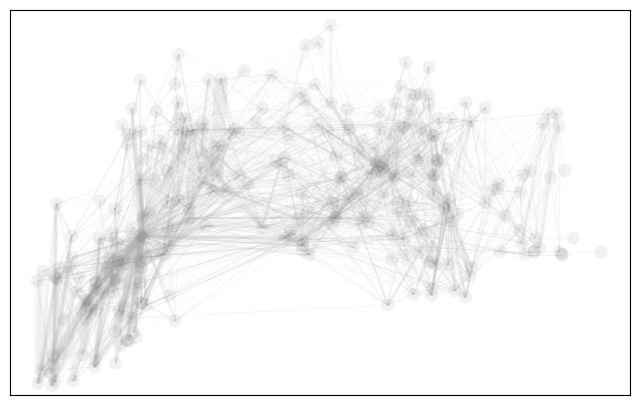

(-1.8, 1.9)

In [30]:
let
    dict_feature = Dict()
    # dict_feature["SAAVL"] = [1,0,0,1]
    # dict_feature["SAAVR"] = [0,1,0,1]
    dict_feature["NSM"] = [0,1,1,1]

    dict_x = Dict(dict_pos_v2_non_p)
    dict_y = Dict(dict_pos_z_non_p)    
    
    
    dict_rgba = dict_feature
    
    figure(figsize=(8,5))
    color_connectome(g_wh_lr, list_muscle_wh_lr, dict_x, dict_y,
        dict_rgba, node_size=90, scatter_edgecolor="k")

    xlim(-0.017,0.0275)
    ylim(-1.8,1.9)


end

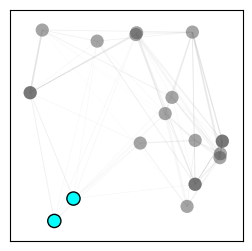

In [31]:
let
    dict_feature = Dict()
    # dict_feature["SAAVL"] = [1,0,0,1]
    # dict_feature["SAAVR"] = [0,1,0,1]
    dict_feature["NSM"] = [0,1,1,1]

    dict_x = Dict(dict_pos_v2_p)
    dict_y = Dict(dict_pos_z_p)    
    
    
    dict_rgba = dict_feature
    
    figure(figsize=(3,3))
    color_connectome(g_wh_lr, list_muscle_wh_lr, dict_x, dict_y,
        dict_rgba, node_size=90, scatter_edgecolor="k",default_rgba=[0.3,0.3,0.3,0.5])

    # xlim(-0.017,0.0275)
    # ylim(-1.8,1.9)


end

In [32]:
function weighted_blend_hsl(c1::HSL, c2::HSL, c3::HSL, w1::Real, w2::Real, w3::Real)
    total_weight = w1 + w2 + w3
    
    blended_hue = (
        w1 * c1.h +
        w2 * c2.h +
        w3 * c3.h
    ) / 3

    blended_saturation = (
        w1 * c1.s +
        w2 * c2.s +
        w3 * c3.s
    ) / 3

    blended_lightness = (
        w1 * c1.l +
        w2 * c2.l +
        w3 * c3.l
    ) / 3

    blended_color_hsl = HSL(blended_hue, blended_saturation, blended_lightness)
   
    return blended_color_hsl
end

using Colors

function weighted_blend_rgb(c1::RGB, c2::RGB, c3::RGB, w1::Real, w2::Real, w3::Real)
    total_weight = 3 #w1 + w2 + w3

    blended_red = (
        w1 * red(c1) +
        w2 * red(c2) +
        w3 * red(c3)
    ) / total_weight

    blended_green = (
        w1 * green(c1) +
        w2 * green(c2) +
        w3 * green(c3)
    ) / total_weight

    blended_blue = (
        w1 * blue(c1) +
        w2 * blue(c2) +
        w3 * blue(c3)
    ) / total_weight

    blended_color_rgb = RGB(blended_red, blended_green, blended_blue)
    return blended_color_rgb
end

function RGBA_vector(c)
    [red(c), green(c), blue(c), alpha(c)]
end

function RGB_vector(c)
    [red(c), green(c), blue(c)]
end

RGB_vector (generic function with 1 method)

### without KDE

#### empty

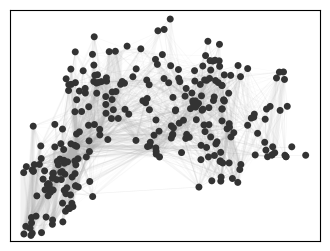

In [33]:
let
    dict_feature = Dict()
    for (k,v) = hb_model_rel_enc
        enc_strength =  v["var"]
        dict_feature[k] = collect(enc_strength .* [v["v"], v["θh"], v["P"]])
    end
        
    dict_x = Dict(dict_pos_v2_non_p)
    dict_y = Dict(dict_pos_z_non_p)
    
    #### connectome graph
    g = py_copy.deepcopy(g_wh_lr)
    
    vmin, vmax = 0., 0.3
    dict_rgba = Dict()
    
    figure(figsize=(4,3))
    color_connectome(g_wh_lr, list_muscle_wh_lr, dict_x, dict_y,
        dict_rgba, node_size=25, scatter_edgecolor=[0.2,0.2,0.2,1],
        default_rgba=[0.2,0.2,0.2,1.])
    xlim(-0.017,0.0275)
    ylim(-1.8,1.9)
    savefig(joinpath(path_fig_root, "connectome_non_p_empty.pdf"))
end

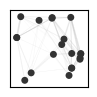

In [34]:
let
    dict_feature = Dict()
    for (k,v) = hb_model_rel_enc
        enc_strength =  v["var"]
        dict_feature[k] = collect(enc_strength .* [v["v"], v["θh"], v["P"]])
    end
        
    dict_x = Dict(dict_pos_v2_p)
    dict_y = Dict(dict_pos_z_p)
    
    #### connectome graph
    g = py_copy.deepcopy(g_wh_lr)
    
    vmin, vmax = 0., 0.3
    dict_rgba = Dict()
    
    figure(figsize=(1,1))
    color_connectome(g_wh_lr, list_muscle_wh_lr, dict_x, dict_y,
        dict_rgba, node_size=25, scatter_edgecolor=[0.2,0.2,0.2,1],
        default_rgba=[0.2,0.2,0.2,1.])

    savefig(joinpath(path_fig_root, "connectome_p_empty.pdf"))
end

#### colored

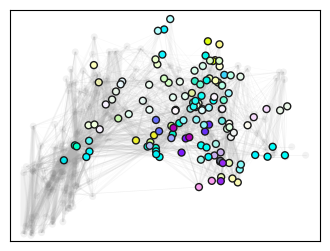

In [33]:
let
    dict_feature = Dict()
    for (k,v) = hb_model_rel_enc
        enc_strength =  v["var"]
        dict_feature[k] = collect(enc_strength .* [v["v"], v["θh"], v["P"]])
    end
        
    dict_x = Dict(dict_pos_v2_non_p)
    dict_y = Dict(dict_pos_z_non_p)
    
    #### connectome graph
    g = py_copy.deepcopy(g_wh_lr)
    
    vmin, vmax = 0., 0.3
    dict_rgba = Dict()
    
    c1 = parse(Colorant, "cyan")
    c2 = parse(Colorant, "magenta")
    c3 = parse(Colorant, "yellow")
    
    # Convert colors to HSL
    hsl_c1 = convert(HSL, c1)
    hsl_c2 = convert(HSL, c2)
    hsl_c3 = convert(HSL, c3)

    # Define the rotation angle (in degrees)
    rotation_angle = 0 # You can choose any rotation angle

    # Rotate the colors by adjusting the hue
    hsl_c1_rot = HSL(mod(hsl_c1.h + rotation_angle, 360), hsl_c1.s, hsl_c1.l)
    hsl_c2_rot = HSL(mod(hsl_c2.h + rotation_angle, 360), hsl_c2.s, hsl_c2.l)
    hsl_c3_rot = HSL(mod(hsl_c3.h + rotation_angle, 360), hsl_c3.s, hsl_c3.l)
    rgb_c1_rot = convert(RGB, hsl_c1_rot)
    rgb_c2_rot = convert(RGB, hsl_c2_rot)
    rgb_c3_rot = convert(RGB, hsl_c3_rot)
    rgb_c1_rot_vec = RGB_vector(rgb_c1_rot)
    rgb_c2_rot_vec = RGB_vector(rgb_c2_rot)
    rgb_c3_rot_vec = RGB_vector(rgb_c3_rot)
    
    for (k,v) = dict_feature
        # list_x_ = [1 .- rescale_to_range(v[i], vmin, vmax) for i = 1:3]
        w_c1 = rescale_to_range(v[1], vmin, vmax)
        w_c2 = rescale_to_range(v[2], vmin, vmax)
        w_c3 = rescale_to_range(v[3], vmin, vmax)
        
        c_hsl = convert(HSL, RGB(w_c1, w_c2, w_c3))
        c_hsl_rot = HSL(mod(c_hsl.h + rotation_angle, 360), c_hsl.s, c_hsl.l)
        c_rgb = convert(RGB, c_hsl_rot)
        dict_rgba[k] = [1 - red(c_rgb), 1 - green(c_rgb), 1 - blue(c_rgb), 1.]
    end

    p1 = percentile([v[1] for (k,v) = dict_feature], 80)
    p2 = percentile([v[2] for (k,v) = dict_feature], 80)
    p3 = percentile([v[3] for (k,v) = dict_feature], 80)
    
    figure(figsize=(4,3))
    color_connectome(g_wh_lr, list_muscle_wh_lr, dict_x, dict_y,
        dict_rgba, node_size=25, scatter_edgecolor=[0.1,0.1,0.1,1])
    xlim(-0.017,0.0275)
    ylim(-1.8,1.9)
    savefig(joinpath(path_fig_root, "connectome_non_p_v1.pdf"))
end

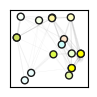

In [34]:
let
    dict_feature = Dict()
    for (k,v) = hb_model_rel_enc
        enc_strength =  v["var"]
        dict_feature[k] = collect(enc_strength .* [v["v"], v["θh"], v["P"]])
    end
        
    dict_x = Dict(dict_pos_v2_p)
    dict_y = Dict(dict_pos_z_p)
    
    #### connectome graph
    g = py_copy.deepcopy(g_wh_lr)
    
    vmin, vmax = 0., 0.3
    dict_rgba = Dict()
    
    c1 = parse(Colorant, "cyan")
    c2 = parse(Colorant, "magenta")
    c3 = parse(Colorant, "yellow")
    
    # Convert colors to HSL
    hsl_c1 = convert(HSL, c1)
    hsl_c2 = convert(HSL, c2)
    hsl_c3 = convert(HSL, c3)

    # Define the rotation angle (in degrees)
    rotation_angle = 0 # You can choose any rotation angle

    # Rotate the colors by adjusting the hue
    hsl_c1_rot = HSL(mod(hsl_c1.h + rotation_angle, 360), hsl_c1.s, hsl_c1.l)
    hsl_c2_rot = HSL(mod(hsl_c2.h + rotation_angle, 360), hsl_c2.s, hsl_c2.l)
    hsl_c3_rot = HSL(mod(hsl_c3.h + rotation_angle, 360), hsl_c3.s, hsl_c3.l)
    rgb_c1_rot = convert(RGB, hsl_c1_rot)
    rgb_c2_rot = convert(RGB, hsl_c2_rot)
    rgb_c3_rot = convert(RGB, hsl_c3_rot)
    rgb_c1_rot_vec = RGB_vector(rgb_c1_rot)
    rgb_c2_rot_vec = RGB_vector(rgb_c2_rot)
    rgb_c3_rot_vec = RGB_vector(rgb_c3_rot)
    
    for (k,v) = dict_feature
        # list_x_ = [1 .- rescale_to_range(v[i], vmin, vmax) for i = 1:3]
        w_c1 = rescale_to_range(v[1], vmin, vmax)
        w_c2 = rescale_to_range(v[2], vmin, vmax)
        w_c3 = rescale_to_range(v[3], vmin, vmax)
        
        c_hsl = convert(HSL, RGB(w_c1, w_c2, w_c3))
        c_hsl_rot = HSL(mod(c_hsl.h + rotation_angle, 360), c_hsl.s, c_hsl.l)
        c_rgb = convert(RGB, c_hsl_rot)
        dict_rgba[k] = [1 - red(c_rgb), 1 - green(c_rgb), 1 - blue(c_rgb), 1.]
    end

    p1 = percentile([v[1] for (k,v) = dict_feature], 80)
    p2 = percentile([v[2] for (k,v) = dict_feature], 80)
    p3 = percentile([v[3] for (k,v) = dict_feature], 80)
    
    figure(figsize=(1,1))
    color_connectome(g_wh_lr, list_muscle_wh_lr, dict_x, dict_y,
        dict_rgba, node_size=25, scatter_edgecolor=[0.1,0.1,0.1,1.])
    # xlim(-0.017,0.025)
    # ylim(-1.8,1.9)
    savefig(joinpath(path_fig_root, "connectome_p_v1.pdf"))
end

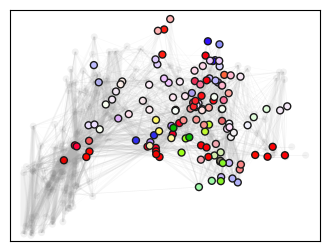

In [35]:
let
    dict_feature = Dict()
    for (k,v) = hb_model_rel_enc
        enc_strength =  v["var"]
        dict_feature[k] = collect(enc_strength .* [v["v"], v["θh"], v["P"]])
    end
        
    dict_x = Dict(dict_pos_v2_non_p)
    dict_y = Dict(dict_pos_z_non_p)
    
    #### connectome graph
    g = py_copy.deepcopy(g_wh_lr)
    
    vmin, vmax = 0., 0.3
    dict_rgba = Dict()
    
    c1 = parse(Colorant, "red")
    c2 = parse(Colorant, "green")
    c3 = parse(Colorant, "blue")
    
    # Convert colors to HSL
    hsl_c1 = convert(HSL, c1)
    hsl_c2 = convert(HSL, c2)
    hsl_c3 = convert(HSL, c3)

    # Define the rotation angle (in degrees)
    rotation_angle = 180 # You can choose any rotation angle

    # Rotate the colors by adjusting the hue
    hsl_c1_rot = HSL(mod(hsl_c1.h + rotation_angle, 360), hsl_c1.s, hsl_c1.l)
    hsl_c2_rot = HSL(mod(hsl_c2.h + rotation_angle, 360), hsl_c2.s, hsl_c2.l)
    hsl_c3_rot = HSL(mod(hsl_c3.h + rotation_angle, 360), hsl_c3.s, hsl_c3.l)
    rgb_c1_rot = convert(RGB, hsl_c1_rot)
    rgb_c2_rot = convert(RGB, hsl_c2_rot)
    rgb_c3_rot = convert(RGB, hsl_c3_rot)
    rgb_c1_rot_vec = RGB_vector(rgb_c1_rot)
    rgb_c2_rot_vec = RGB_vector(rgb_c2_rot)
    rgb_c3_rot_vec = RGB_vector(rgb_c3_rot)
    
    for (k,v) = dict_feature
        # list_x_ = [1 .- rescale_to_range(v[i], vmin, vmax) for i = 1:3]
        w_c1 = rescale_to_range(v[1], vmin, vmax)
        w_c2 = rescale_to_range(v[2], vmin, vmax)
        w_c3 = rescale_to_range(v[3], vmin, vmax)
        
        c_hsl = convert(HSL, RGB(w_c1, w_c2, w_c3))
        c_hsl_rot = HSL(mod(c_hsl.h + rotation_angle, 360), c_hsl.s, c_hsl.l)
        c_rgb = convert(RGB, c_hsl_rot)
        dict_rgba[k] = [1 - red(c_rgb), 1 - green(c_rgb), 1 - blue(c_rgb), 1.]
    end

    p1 = percentile([v[1] for (k,v) = dict_feature], 80)
    p2 = percentile([v[2] for (k,v) = dict_feature], 80)
    p3 = percentile([v[3] for (k,v) = dict_feature], 80)
    
    figure(figsize=(4,3))
    color_connectome(g_wh_lr, list_muscle_wh_lr, dict_x, dict_y,
        dict_rgba, node_size=25, scatter_edgecolor=[0.1,0.1,0.1,1])
    xlim(-0.017,0.0275)
    ylim(-1.8,1.9)
    savefig(joinpath(path_fig_root, "connectome_non_p_v2.pdf"))
end

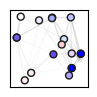

In [36]:
let
    dict_feature = Dict()
    for (k,v) = hb_model_rel_enc
        enc_strength =  v["var"]
        dict_feature[k] = collect(enc_strength .* [v["v"], v["θh"], v["P"]])
    end
        
    dict_x = Dict(dict_pos_v2_p)
    dict_y = Dict(dict_pos_z_p)
    
    #### connectome graph
    g = py_copy.deepcopy(g_wh_lr)
    
    vmin, vmax = 0., 0.3
    dict_rgba = Dict()
        
    c1 = parse(Colorant, "red")
    c2 = parse(Colorant, "green")
    c3 = parse(Colorant, "blue")
    
    # Convert colors to HSL
    hsl_c1 = convert(HSL, c1)
    hsl_c2 = convert(HSL, c2)
    hsl_c3 = convert(HSL, c3)

    # Define the rotation angle (in degrees)
    rotation_angle = 180 # You can choose any rotation angle

    # Rotate the colors by adjusting the hue
    hsl_c1_rot = HSL(mod(hsl_c1.h + rotation_angle, 360), hsl_c1.s, hsl_c1.l)
    hsl_c2_rot = HSL(mod(hsl_c2.h + rotation_angle, 360), hsl_c2.s, hsl_c2.l)
    hsl_c3_rot = HSL(mod(hsl_c3.h + rotation_angle, 360), hsl_c3.s, hsl_c3.l)
    rgb_c1_rot = convert(RGB, hsl_c1_rot)
    rgb_c2_rot = convert(RGB, hsl_c2_rot)
    rgb_c3_rot = convert(RGB, hsl_c3_rot)
    rgb_c1_rot_vec = RGB_vector(rgb_c1_rot)
    rgb_c2_rot_vec = RGB_vector(rgb_c2_rot)
    rgb_c3_rot_vec = RGB_vector(rgb_c3_rot)
    
    for (k,v) = dict_feature
        # list_x_ = [1 .- rescale_to_range(v[i], vmin, vmax) for i = 1:3]
        w_c1 = rescale_to_range(v[1], vmin, vmax)
        w_c2 = rescale_to_range(v[2], vmin, vmax)
        w_c3 = rescale_to_range(v[3], vmin, vmax)
        
        c_hsl = convert(HSL, RGB(w_c1, w_c2, w_c3))
        c_hsl_rot = HSL(mod(c_hsl.h + rotation_angle, 360), c_hsl.s, c_hsl.l)
        c_rgb = convert(RGB, c_hsl_rot)
        dict_rgba[k] = [1 - red(c_rgb), 1 - green(c_rgb), 1 - blue(c_rgb), 1.]
    end

    p1 = percentile([v[1] for (k,v) = dict_feature], 80)
    p2 = percentile([v[2] for (k,v) = dict_feature], 80)
    p3 = percentile([v[3] for (k,v) = dict_feature], 80)
    
    figure(figsize=(1,1))
    color_connectome(g_wh_lr, list_muscle_wh_lr, dict_x, dict_y,
        dict_rgba, node_size=25, scatter_edgecolor=[0.1,0.1,0.1,1.])
    # xlim(-0.017,0.025)
    # ylim(-1.8,1.9)
    savefig(joinpath(path_fig_root, "connectome_p_v2.pdf"))
end

### behavior

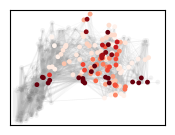

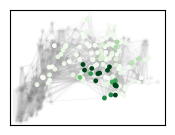

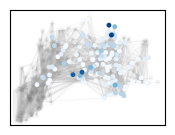

In [34]:
let
    dict_feature = Dict()
    for (k,v) = hb_model_rel_enc
        enc_strength =  v["var"]
        dict_feature[k] = collect(enc_strength .* [v["v"], v["θh"], v["P"]])
    end
        
    dict_x = Dict(dict_pos_v2_non_p)
    dict_y = Dict(dict_pos_z_non_p)
    
    #### connectome graph
    g = py_copy.deepcopy(g_wh_lr)
    
    
    for (i_b, (b_name, cmap_, vmax_)) = enumerate(zip(["v","hc","p"],["Reds","Greens","Blues"],[0.3,0.15,0.3]))
        cmap = ColorMap(cmap_)
        vmin, vmax = 0., vmax_
        dict_rgba = Dict()    
        for (k,v) = dict_feature
            v_ = rescale_to_range(dict_feature[k][i_b], vmin, vmax)
            dict_rgba[k] = collect(cmap(v_))
        end
        
        scatter_edgecolor = "none" # [0.1,0.1,0.1,1]

        
        
    list_node_order = []
    for neuron = keys(dict_x)
        q_color_saved = false
        if !occursin(r"[A-Z]{2}\d", neuron) # check if not vc motor
            if haskey(dict_rgba, neuron) 
                # neuron provided with or the class does not have dv & lr
                push!(list_node_order, (neuron, dict_feature[neuron][i_b]))
                q_color_saved = true
            else
                class, dv, lr = get_neuron_class(neuron)
                
                class_dv = class
                if !(dv == "missing" || dv == "undefined")
                    class_dv = class * dv
                end
                
                if haskey(dict_rgba, class_dv)
                    push!(list_node_order, (neuron, dict_feature[class_dv][i_b]))
                    q_color_saved = true
                else
                    # println("$class missing in class dict")
                end
            end
        end # if not vc motor
        
        if !q_color_saved
            push!(list_node_order, (neuron, -1))
        end
    end
    
    
    list_order = map(x->x[1], sort(list_node_order, by=x->x[2], rev=true))


    figsize_big = [4,3]
        figure(figsize=Tuple(0.5 * figsize_big))
        color_connectome(g_wh_lr, list_muscle_wh_lr, dict_x, dict_y,
            dict_rgba, node_size=12, scatter_edgecolor=scatter_edgecolor, node_plot_order=reverse(list_order))
        xlim(-0.017,0.0275)
        ylim(-1.8,1.9)
        savefig(joinpath(path_fig_root, "connectome_non_p_b_$b_name.pdf"))
    end
end

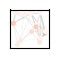

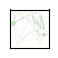

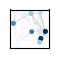

In [35]:
let
    dict_feature = Dict()
    for (k,v) = hb_model_rel_enc
        enc_strength =  v["var"]
        dict_feature[k] = collect(enc_strength .* [v["v"], v["θh"], v["P"]])
    end
        
    dict_x = Dict(dict_pos_v2_p)
    dict_y = Dict(dict_pos_z_p)
    
    #### connectome graph
    g = py_copy.deepcopy(g_wh_lr)
    
    
    for (i_b, (b_name, cmap_,vmax_)) = enumerate(zip(["v","hc","p"],["Reds","Greens","Blues"],[0.3,0.15,0.3]))
        cmap = ColorMap(cmap_)
        vmin, vmax = 0., vmax_
        dict_rgba = Dict()    
        for (k,v) = dict_feature
            v_ = rescale_to_range(dict_feature[k][i_b], vmin, vmax)
            dict_rgba[k] = collect(cmap(v_))
        end


        scatter_edgecolor = "none" # [0.1,0.1,0.1,1]

    figsize_big = [1,1]
        figure(figsize=Tuple(0.5 * figsize_big))
        color_connectome(g_wh_lr, list_muscle_wh_lr, dict_x, dict_y,
            dict_rgba, node_size=12, scatter_edgecolor=scatter_edgecolor)
        savefig(joinpath(path_fig_root, "connectome_p_b_$b_name.pdf"))
    end
end

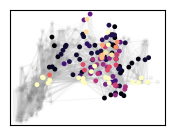

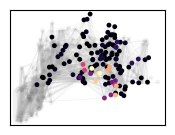

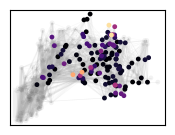

In [39]:
let
    dict_feature = Dict()
    for (k,v) = hb_model_rel_enc
        enc_strength =  v["var"]
        dict_feature[k] = collect(enc_strength .* [v["v"], v["θh"], v["P"]])
    end
        
    dict_x = Dict(dict_pos_v2_non_p)
    dict_y = Dict(dict_pos_z_non_p)
    
    #### connectome graph
    g = py_copy.deepcopy(g_wh_lr)
    
    
    for (i_b, (b_name, cmap_)) = enumerate(zip(["v","hc","p"],["magma","magma","magma"]))
        cmap = ColorMap(cmap_)
        vmin, vmax = 0., 0.3
        dict_rgba = Dict()    
        for (k,v) = dict_feature
            v_ = rescale_to_range(dict_feature[k][i_b], vmin, vmax)
            dict_rgba[k] = collect(cmap(v_))
        end
        
        scatter_edgecolor = "none" # [0.1,0.1,0.1,1]

        
        
    list_node_order = []
    for neuron = keys(dict_x)
        q_color_saved = false
        if !occursin(r"[A-Z]{2}\d", neuron) # check if not vc motor
            if haskey(dict_rgba, neuron) 
                # neuron provided with or the class does not have dv & lr
                push!(list_node_order, (neuron, dict_feature[neuron][i_b]))
                q_color_saved = true
            else
                class, dv, lr = get_neuron_class(neuron)
                
                class_dv = class
                if !(dv == "missing" || dv == "undefined")
                    class_dv = class * dv
                end
                
                if haskey(dict_rgba, class_dv)
                    push!(list_node_order, (neuron, dict_feature[class_dv][i_b]))
                    q_color_saved = true
                else
                    # println("$class missing in class dict")
                end
            end
        end # if not vc motor
        
        if !q_color_saved
            push!(list_node_order, (neuron, -1))
        end
    end
    
    
    list_order = map(x->x[1], sort(list_node_order, by=x->x[2], rev=true))


    figsize_big = [4,3]
        figure(figsize=Tuple(0.5 * figsize_big))
        color_connectome(g_wh_lr, list_muscle_wh_lr, dict_x, dict_y,
            dict_rgba, node_size=12, scatter_edgecolor=scatter_edgecolor, node_plot_order=reverse(list_order))
        xlim(-0.017,0.0275)
        ylim(-1.8,1.9)
        savefig(joinpath(path_fig_root, "connectome_non_p_b_$(b_name)_viridis.pdf"))
    end
end

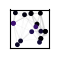

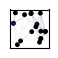

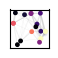

In [40]:
let
    dict_feature = Dict()
    for (k,v) = hb_model_rel_enc
        enc_strength =  v["var"]
        dict_feature[k] = collect(enc_strength .* [v["v"], v["θh"], v["P"]])
    end
        
    dict_x = Dict(dict_pos_v2_p)
    dict_y = Dict(dict_pos_z_p)
    
    #### connectome graph
    g = py_copy.deepcopy(g_wh_lr)
    
    
    for (i_b, (b_name, cmap_)) = enumerate(zip(["v","hc","p"],["magma","magma","magma"]))
        cmap = ColorMap(cmap_)
        vmin, vmax = 0., 0.3
        dict_rgba = Dict()    
        for (k,v) = dict_feature
            v_ = rescale_to_range(dict_feature[k][i_b], vmin, vmax)
            dict_rgba[k] = collect(cmap(v_))
        end


        scatter_edgecolor = "none" # [0.1,0.1,0.1,1]

    figsize_big = [1,1]
        figure(figsize=Tuple(0.5 * figsize_big))
        color_connectome(g_wh_lr, list_muscle_wh_lr, dict_x, dict_y,
            dict_rgba, node_size=12, scatter_edgecolor=scatter_edgecolor)
        savefig(joinpath(path_fig_root, "connectome_p_b_$(b_name)_viridis.pdf"))
    end
end

## Plot - marginal

In [41]:
pos_z_bins = -1:((1.9+1)/3):1.9
pos_v2_bins = -0.017:((0.017+0.025)/3):0.0275;

### EWMA

cutoff: 15.43045895650785
vmin: 3.0
vmax: 15.0
neuron selected: 17 percentage: 16.83
random sampling among the recorded neurons. trial: 10000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


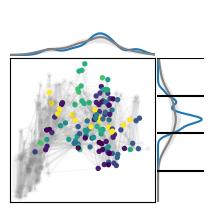

In [35]:
let
    dict_tau, dict_n = neuropal_aggregate_data(list_dict_fit, list_match_dict, list_uid_use_all, list_class_dv_ordered,
        f_aggregate_dataset=median, f_process=get_tau, f_aggregate_rg_t=median, merge_rg_t=true)
    
    dict_feature = dict_tau

    dict_x = Dict(dict_pos_v2_non_p)
    dict_y = Dict(dict_pos_z_non_p)

    #### connectome graph
    g = py_copy.deepcopy(g_wh_lr)

    #### cmap range
    dist_feature = vcat([v[1] for (k,v) = dict_feature]...)

    cutoff_feature = percentile(dist_feature, 85)
    println("cutoff: $cutoff_feature")
    
    vmin = 3.
    vmax = 15.
    println("vmin: $vmin")
    println("vmax: $vmax")
    
    
    cmap = ColorMap("viridis")    
    
    #### plot
    f_select = x->x>cutoff_feature # function to select (for the blue line on the KDE)
    ax_main, ax_vertical, ax_horizontal = color_connectome_kde(g, list_muscle_wh_lr, dict_x, dict_y, dict_feature, f_select, vmin=vmin, vmax=vmax,
        n_control=10000, cmap=cmap, node_size=15, figsize=(2.5, 2.5), xlim_scatter=(-0.017,0.0275), ylim_scatter=(-1.8,1.9))

    for y = pos_z_bins
        ax_vertical.axhline(y, color="k")
    end
    
    # savefig(joinpath(path_fig_root, "connectome_ewma.pdf"))
end

### Variability

cutoff: 1.7331252875845649
vmin: 1.0
vmax: 1.9
neuron selected: 19 percentage: 18.45
random sampling among the recorded neurons. trial: 10000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


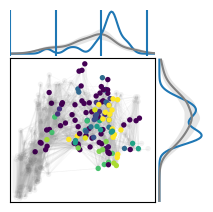

In [47]:
let
    dict_feature = hb_model_result["variability"]

    dict_x = Dict(dict_pos_v2_non_p)
    dict_y = Dict(dict_pos_z_non_p)

    #### connectome graph
    g = py_copy.deepcopy(g_wh_lr)

    #### cmap range
    dist_feature = vcat([v[1] for (k,v) = dict_feature]...)

    cutoff_feature = percentile(dist_feature, 85)
    println("cutoff: $cutoff_feature")
    
    vmin = 1.
    vmax = 1.9
    println("vmin: $vmin")
    println("vmax: $vmax")
    
    cmap = ColorMap("viridis")    
    
    #### plot
    f_select = x->x>cutoff_feature # function to select (for the blue line on the KDE)
    ax_main, ax_vertical, ax_horizontal = color_connectome_kde(g, list_muscle_wh_lr, dict_x, dict_y, dict_feature, f_select, vmin=vmin, vmax=vmax,
        n_control=10000, cmap=cmap, node_size=15, figsize=(2.5, 2.5), xlim_scatter=(-0.017,0.0275), ylim_scatter=(-1.8,1.9))

    for x = collect(pos_v2_bins)
        ax_horizontal.axvline(x)
    end
    
    savefig(joinpath(path_fig_root, "connectome_high_var.pdf"))
end

vmin: 1.0
vmax: 1.9
neuron selected: 19 percentage: 18.45
random sampling among the recorded neurons. trial: 10000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


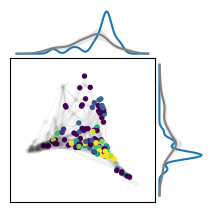

In [48]:
let
    dict_feature = hb_model_result["variability"]

    dict_x = Dict(dict_pos_v2_non_p)
    dict_y = Dict(dict_pos_v3_non_p)

    #### connectome graph
    g = py_copy.deepcopy(g_wh_lr)

    #### cmap range
    dist_feature = vcat([v[1] for (k,v) = dict_feature]...)

    cutoff_feature = percentile(dist_feature, 85)
    
    vmin = 1.
    vmax = 1.9
    println("vmin: $vmin")
    println("vmax: $vmax")
    
    cmap = ColorMap("viridis")    
    
    #### plot
    f_select = x->x>cutoff_feature # function to select (for the blue line on the KDE)
    color_connectome_kde(g, list_muscle_wh_lr, dict_x, dict_y, dict_feature, f_select, vmin=vmin, vmax=vmax,
        n_control=10000, cmap=cmap, node_size=15, figsize=(2.5, 2.5))

    savefig(joinpath(path_fig_root, "connectome_high_var_v3.pdf"))
end

### Encoding strength

cutoff: 0.4612318836575009
vmin: 0.0
vmax: 0.4
neuron selected: 15 percentage: 14.56
random sampling among the recorded neurons. trial: 10000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


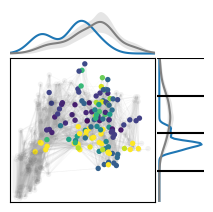

In [49]:
let
    dict_feature = Dict()
    for (k,v) = hb_model_rel_enc

        dict_feature[k] = v["var"]
    end

    dict_x = Dict(dict_pos_v2_non_p)
    dict_y = Dict(dict_pos_z_non_p)

    #### connectome graph
    g = py_copy.deepcopy(g_wh_lr)

    #### cmap range
    dist_feature = vcat([v[1] for (k,v) = dict_feature]...)

    cutoff_feature = percentile(dist_feature, 85)
    println("cutoff: $cutoff_feature")
    
    vmin = 0.
    vmax = 0.4
    println("vmin: $vmin")
    println("vmax: $vmax")
    
    cmap = ColorMap("viridis")    
    
    #### plot
    f_select = x->x>cutoff_feature # function to select (for the blue line on the KDE)
    ax_main, ax_vertical, ax_horizontal = color_connectome_kde(g, list_muscle_wh_lr, dict_x, dict_y, dict_feature, f_select, vmin=vmin, vmax=vmax,
        n_control=10000, cmap=cmap, node_size=15, figsize=(2.5, 2.5), xlim_scatter=(-0.017,0.0275), ylim_scatter=(-1.8,1.9))

    for y = pos_z_bins
        ax_vertical.axhline(y, color="k")
    end

    
    savefig(joinpath(path_fig_root, "connectome_high_enc.pdf"))
end

### Variability - test

#### rand control - shuffle all nodes

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


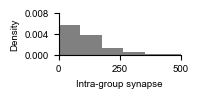

99.92

In [50]:
let
    g = g_wv
    dict_var = hb_model_result["variability"]

    list_neuron_high_var = []
    high_var_threshold = 1.7832115528885724
    n_trial = 10000
    
    for (k,v) = dict_var
        if v > high_var_threshold
            push!(list_neuron_high_var, k)
        end
    end

    list_node_intersect = intersect(g.nodes(), keys(dict_var))
    list_neuron_high_var = intersect(list_node_intersect, list_neuron_high_var)
    n_high_var = length(list_neuron_high_var)
  
    n_inter = 0.
    n_intra = 0.
    for node_i = list_neuron_high_var, node_j = list_neuron_high_var
        if g.has_edge(node_i, node_j)
            n_intra += g.get_edge_data(node_i, node_j)["weight"]
        end
    end
    
    list_node_g = collect(g.nodes())
    list_rand_n_intra = zeros(n_trial)
    @showprogress for i_trial = 1:n_trial
        list_node_rand = sample(list_node_g, n_high_var, replace=false)
        for node_i = list_node_rand, node_j = list_node_rand
            if g.has_edge(node_i, node_j)
                list_rand_n_intra[i_trial] += g.get_edge_data(node_i, node_j)["weight"]
            end
        end
    end
    
    figure(figsize=(2,1))
    hist(list_rand_n_intra, density=true, color="gray")
    axvline(n_intra, color="r")
    xlabel("Intra-group synapse")
    ylabel("Density")
    xlim(0,500)
    ylim(0,0.008)
    yticks(0:0.004:0.008)
    xticks(0:250:500, 0:250:500)
    fix_plot()
    tight_layout()
    
    sort!(list_rand_n_intra)
    searchsortedfirst(list_rand_n_intra,n_intra) / n_trial * 100
end

#### rand control - shuffle recorded only

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


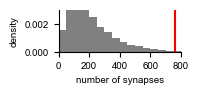

99.22

In [54]:
let
    g = g_wv
    dict_var = hb_model_result["variability"]

    list_neuron_high_var = []
    high_var_threshold = 1.7331252875845649
    n_trial = 10000
    
    list_neuron_lr = ["SAADL","SAADR","IL1L","IL1R","IL2L","IL2R","ASEL","ASER"]

    for (k,v) = dict_var
        if v > high_var_threshold
            if k in list_neuron_lr
                push!(list_neuron_high_var, k[1:end-1])
            else
                push!(list_neuron_high_var, k)
            end
        end
    end
    
    # list_node_intersect = intersect(g.nodes(), keys(dict_var))
    # list_neuron_high_var = intersect(list_node_intersect, list_neuron_high_var)
    n_high_var = length(list_neuron_high_var)
  
    n_inter = 0.
    n_intra = 0.
    for node_i = list_neuron_high_var, node_j = list_neuron_high_var
        if g.has_edge(node_i, node_j)
            n_intra += g.get_edge_data(node_i, node_j)["weight"]
        end
    end
    
    list_node_g = collect(g.nodes())
    list_rand_n_intra = zeros(n_trial)
    @showprogress for i_trial = 1:n_trial
        dict_var_shuffle = shuffle_dict_feature(dict_var)
        list_neuron_high_var_shuffle = String[]
        for (k,v) = dict_var_shuffle
            if v > high_var_threshold
                push!(list_neuron_high_var_shuffle, k)
            end
        end

        for node_i = list_neuron_high_var_shuffle, node_j = list_neuron_high_var_shuffle
            if g.has_edge(node_i, node_j)
                list_rand_n_intra[i_trial] += g.get_edge_data(node_i, node_j)["weight"]
            end
        end
    end
    
    figure(figsize=(2,1))
    hist(list_rand_n_intra, 0:50:800, density=true, color="gray")
    axvline(n_intra, color="r")
    xlabel("number of synapses")
    ylabel("density")

    ylim(0,0.003)
    xlim(0,800)
    
    fix_plot()
    tight_layout()
    
    sort!(list_rand_n_intra)
    searchsortedfirst(list_rand_n_intra,n_intra) / n_trial * 100
end

In [55]:
function test_inter_conenctivity_intra_frac(g, list_node_select; list_node_sample, n_trial::Int=1000)
    n_node_select = length(list_node_select)
    
    list_frac_intra = Float64[]
    for node = list_node_select
        total_in = 0
        total_out = 0
        total_intra_in = 0
        total_intra_out = 0
        
        for (node_from,node_to,edge_data) = g.in_edges(node, data=true)
            syn = edge_data["weight"]
            if node_from in list_node_select && !isnan(syn)
                total_intra_in += syn
            end
            total_in += syn
        end
        
        for (node_from,node_to,edge_data) = g.out_edges(node, data=true)
            syn = edge_data["weight"]
            if node_to in list_node_select && !isnan(syn)
                total_intra_out += syn
            end
            total_out += syn
        end
        
        total = total_in + total_out
        total_intra = total_intra_in + total_intra_out 
        push!(list_frac_intra, total_intra / total)
    end
    intra_frac = mean(list_frac_intra)
   
    
    ## random control
    list_node_intersect = intersect(list_node_sample, g.nodes())
    list_rand_frac_intra = zeros(n_trial)
    @showprogress for i_trial = 1:n_trial
        list_node_rand = sample(list_node_intersect, n_node_select, replace=false)
        list_neuron = list_node_rand
        
        list_frac_intra = Float64[]
        for node = list_neuron
            total_in = 0
            total_out = 0
            total_intra_in = 0
            total_intra_out = 0

            for (node_from,node_to,edge_data) = g.in_edges(node, data=true)
                syn = edge_data["weight"]
                if node_from in list_neuron && !isnan(syn)
                    total_intra_in += syn
                end
                total_in += syn
            end

            for (node_from,node_to,edge_data) = g.out_edges(node, data=true)
                syn = edge_data["weight"]
                if node_to in list_neuron && !isnan(syn)
                    total_intra_out += syn
                end
                total_out += syn
            end

            total = total_in + total_out
            total_intra = total_intra_in + total_intra_out 
            push!(list_frac_intra, total_intra / total)
        end
        
        list_rand_frac_intra[i_trial] = mean(list_frac_intra)
    end
    
    intra_frac, list_rand_frac_intra
end

test_inter_conenctivity_intra_frac (generic function with 1 method)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:22


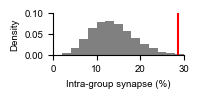

99.49

In [56]:
let
    list_neuron_lr = ["SAADL","SAADR","IL1L","IL1R","IL2L","IL2R","ASEL","ASER"]
    
    g = g_wv
    
    dict_var = hb_model_result["variability"]

    list_node_select_ = String[]
    high_var_threshold = 1.7331252875845649
    n_trial = 10000
    
    for (k,v) = dict_var
        if v > high_var_threshold
            push!(list_node_select_, k)
        end
    end
    
    list_node_sample = String[]
    for node = collect(keys(dict_var))
        if node ∈ list_neuron_lr
            push!(list_node_sample, node[1:end-1])
        else
            push!(list_node_sample, node)
        end
    end
    
    list_node_select = String[]
    for node = list_node_select_
        if node ∈ list_neuron_lr
            push!(list_node_select, node[1:end-1])
        else
            push!(list_node_select, node)
        end
    end
    
    
    intra_frac, list_rand_frac_intra= test_inter_conenctivity_intra_frac(g, list_node_select,
        list_node_sample=list_node_sample, n_trial=n_trial)
    
    figure(figsize=(2,1))
    hist(100 .* list_rand_frac_intra, 0:2:30, density=true, color="gray")
    # println(intra_frac)
    axvline(100*intra_frac, color="r")
    xlabel("Intra-group synapse (%)")
    ylabel("Density")
    ylim(0,0.08)
    yticks(0:0.05:0.1)
    xlim(0,30)
    fix_plot()
    tight_layout()
    savefig(joinpath(path_fig_root, "connectome_high_var_synapse_frac.pdf"))

    sort!(list_rand_frac_intra)
    searchsortedfirst(list_rand_frac_intra, intra_frac) / n_trial * 100    
end

### EWMA test

Progress: 100%|█████████████████████████████████████████| Time: 0:00:18


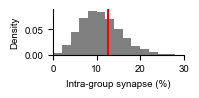

In [57]:
let
    dict_tau, dict_n = neuropal_aggregate_data(list_dict_fit, list_match_dict, list_uid_use_all, list_class_dv_ordered,
        f_aggregate_dataset=median, f_process=get_tau, f_aggregate_rg_t=median, merge_rg_t=true)
    
    dict_feature = dict_tau

    dict_x = Dict(dict_pos_v2_non_p)
    dict_y = Dict(dict_pos_z_non_p)

    #### cmap range
    dist_feature = vcat([v[1] for (k,v) = dict_feature]...)

    cutoff_feature = percentile(dist_feature, 85)

    
    list_neuron_lr = ["SAADL","SAADR","IL1L","IL1R","IL2L","IL2R","ASEL","ASER"]
    
    g = get_graph_white(1,merge_lr=true)
    

    list_node_select_ = String[]
    n_trial = 10000
    
    for (k,v) = dict_feature
        if v > cutoff_feature
            push!(list_node_select_, k)
        end
    end
    
    list_node_sample = String[]
    for node = collect(keys(dict_feature))
        if node ∈ list_neuron_lr
            push!(list_node_sample, node[1:end-1])
        else
            push!(list_node_sample, node)
        end
    end
    
    list_node_select = String[]
    for node = list_node_select_
        if node ∈ list_neuron_lr
            push!(list_node_select, node[1:end-1])
        else
            push!(list_node_select, node)
        end
    end
    
    intra_frac, list_rand_frac_intra= test_inter_conenctivity_intra_frac(g, list_node_select,
        list_node_sample=list_node_sample, n_trial=n_trial)
    
    figure(figsize=(2,1))
    hist(100 .* list_rand_frac_intra, 0:2:30, density=true, color="gray")
    # println(intra_frac)
    axvline(100*intra_frac, color="r")
    xlabel("Intra-group synapse (%)")
    ylabel("Density")
#     ylim(0,0.08)
    yticks(0:0.05:0.1)
    xlim(0,30)
    fix_plot()
    tight_layout()
#     # savefig(joinpath(path_fig_root, "connectome_high_var_synapse_frac.pdf"))

#     sort!(list_rand_frac_intra)
#     searchsortedfirst(list_rand_frac_intra, intra_frac) / n_trial * 100    
end

### Enc strength - test

In [717]:
let
    dict_feature = Dict()
    for (k,v) = hb_model_rel_enc

        dict_feature[k] = v["var"]
    end

    dict_x = Dict(dict_pos_v2_non_p)
    dict_y = Dict(dict_pos_z_non_p)

    #### cmap range
    dist_feature = vcat([v[1] for (k,v) = dict_feature]...)

    cutoff_feature = percentile(dist_feature, 85)

    
    list_neuron_lr = ["SAADL","SAADR","IL1L","IL1R","IL2L","IL2R","ASEL","ASER"]
    
    g = g_wv#get_graph_white(1,merge_lr=true)
    

    list_node_select_ = String[]
    n_trial = 100
    
    for (k,v) = dict_feature
        if v > cutoff_feature
            push!(list_node_select_, k)
        end
    end
    
    list_node_sample = String[]
    for node = collect(keys(dict_feature))
        node_ = node
        if node ∈ list_neuron_lr
            node_ = node[1:end-1]
        end
        
        if node_ ∈ g.nodes()
            push!(list_node_sample, node_)
        end
    end
    
    list_node_select = String[]
    for node = list_node_select_
        if node ∈ list_neuron_lr
            push!(list_node_select, node[1:end-1])
        else
            push!(list_node_select, node)
        end
    end
    
    intra_frac, list_rand_frac_intra= test_inter_conenctivity_intra_frac(g, list_node_select,
        list_node_sample=list_node_sample, n_trial=n_trial)
    
#     figure(figsize=(2,1))
#     hist(100 .* list_rand_frac_intra, 0:2:30, density=true, color="gray")
#     # println(intra_frac)
#     axvline(100*intra_frac, color="r")
#     xlabel("Intra-group synapse (%)")
#     ylabel("Density")
# #     ylim(0,0.08)
#     yticks(0:0.05:0.1)
#     xlim(0,30)
#     fix_plot()
#     tight_layout()
#     # savefig(joinpath(path_fig_root, "connectome_high_var_synapse_frac.pdf"))

#     sort!(list_rand_frac_intra)
#     searchsortedfirst(list_rand_frac_intra, intra_frac) / n_trial * 100    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


(NaN, [0.1263995500211311, 0.18358503358546863, 0.16088927592933608, 0.12810847980074955, 0.1569086296636252, 0.22863984802569007, 0.11487668766872895, 0.13903463294762117, 0.09854542321871504, 0.17813360593231653  …  0.1333291302507136, 0.16298562356165927, 0.1533448743179307, 0.10578589902073238, 0.16358232709237652, 0.11344217286222924, 0.154901232164379, 0.09761521502491889, 0.11457796663323756, 0.09049377545270368])

## Stats test marginal KDE

### EWMA

In [35]:
function test_signifiance_connectome(dict_axis::Dict, dict_feature::Dict, f_select::Function, bins)
    list_all = Float64[]
    list_select = Float64[]

    for (neuron,x) = dict_axis
        if !occursin(r"[A-Z]{2}\d", neuron) # check if not vc motor
            if haskey(dict_feature, neuron) 
                # neuron provided with or the class does not have dv & lr
                
                push!(list_all, x)
                v = dict_feature[neuron]
                if f_select(v)
                    push!(list_select, x)
                end
            else
                class, dv, lr = get_neuron_class(neuron)
                
                class_dv = class
                if !(dv == "missing" || dv == "undefined")
                    class_dv = class * dv
                end
                
                if haskey(dict_feature, class_dv)
                    push!(list_all, x)
                    v = dict_feature[class_dv]
                    if f_select(v)
                        push!(list_select, x)
                    end
                else
                    # println("$class missing in class dict")
                end
            end
        end # if not vc motor
    end
    
    for range_bin_indices = 1:(length(bins) - 1)
    
        # observed frequencies
        observed = fit(Histogram, list_all, bins).weights
        observed_special = fit(Histogram, list_select, bins).weights

        # the proportion of selected in the range of interest
        observed_proportion = sum(observed_special[range_bin_indices]) / sum(observed_special)

        # expected proportion of selected points in the range of interest
        expected_proportion = sum(observed[range_bin_indices]) / sum(observed)

        p_hat = observed_proportion
        p_pop = expected_proportion
        n = sum(observed_special)

        z_score = (p_hat - p_pop) / sqrt((p_pop * (1 - p_pop))/(n))
        p_value = 2 * (1 - cdf(Normal(), abs(z_score)))
        
        println("bin start: $(bins[range_bin_indices]) p_val: $p_value")
    end
    
    nothing
end

test_signifiance_connectome (generic function with 1 method)

In [38]:
let
    dict_tau, dict_n = neuropal_aggregate_data(list_dict_fit, list_match_dict, list_uid_use_all, list_class_dv_ordered,
        f_aggregate_dataset=median, f_process=get_tau, f_aggregate_rg_t=median, merge_rg_t=true)
    
    dict_feature = dict_tau

    dict_x = Dict(dict_pos_v2_non_p)
    dict_y = Dict(dict_pos_z_non_p)

    bins_v2 = -0.017:((0.017+0.025)/3):0.025
    bins_pd = -1:((1.9+1)/3):1.9
    
    dict_feature = dict_tau
    f_select(x) = x > 15

    test_signifiance_connectome(dict_y, dict_feature, f_select, bins_pd)
end

bin start: -1.0 p_val: 0.0017991852611298764
bin start: -0.03333333333333333 p_val: 0.0003954430575920931
bin start: 0.9333333333333333 p_val: 0.4146911857186115


cutoff: 15.43045895650785
neuron selected: 17 percentage: 16.83
random sampling among the recorded neurons. trial: 100
bin start: -1.0 p_val: 0.0017991852611298764
bin start: -0.03333333333333333 p_val: 0.0003954430575920931
bin start: 0.9333333333333333 p_val: 0.4146911857186115


┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/BgrVj/src/kolmogorov_smirnov.jl:167


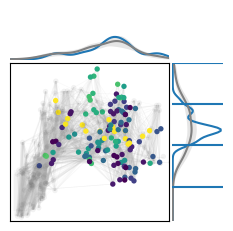

Approximate two sample Kolmogorov-Smirnov test
----------------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.379845

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           0.0262

Details:
    number of observations:   [129,17]
    KS-statistic:              1.4721404896690886


In [49]:
let
    dict_tau, dict_n = neuropal_aggregate_data(list_dict_fit, list_match_dict, list_uid_use_all, list_class_dv_ordered,
        f_aggregate_dataset=median, f_process=get_tau, f_aggregate_rg_t=median, merge_rg_t=true)
    
    dict_feature = dict_tau

    dict_x = Dict(dict_pos_v2_non_p)
    dict_y = Dict(dict_pos_z_non_p)

    dist_feature = vcat([v[1] for (k,v) = dict_feature]...)

    cutoff_feature = percentile(dist_feature, 85)
    println("cutoff: $cutoff_feature")
    
    list_all = Float64[]
    list_select = Float64[]
    for (neuron,y) = dict_y
        if !occursin(r"[A-Z]{2}\d", neuron) # check if not vc motor
            if haskey(dict_feature, neuron) 
                # neuron provided with or the class does not have dv & lr
                
                push!(list_all, y)
                v = dict_feature[neuron]
                if v > cutoff_feature
                    push!(list_select, y)
                end
            else
                class, dv, lr = get_neuron_class(neuron)
                
                class_dv = class
                if !(dv == "missing" || dv == "undefined")
                    class_dv = class * dv
                end
                
                if haskey(dict_feature, class_dv)
                    push!(list_all, y)
                    v = dict_feature[class_dv]
                    if v > cutoff_feature
                        push!(list_select, y)
                    end
                else
                    # println("$class missing in class dict")
                end
            end
        end # if not vc motor
    end
    
    
    bins = -1:((1.9+1)/3):1.9
    # range_of_interest = (0.05,0.975)  # Replace with your range of interest
    # range_bin_indices = 3 #findall(x -> range_of_interest[1] <= x <= range_of_interest[2], bins)[1:end-1]
    
    g = g_wh_lr
    
    vmin = 3.
    vmax = 15.    
    
    cmap = ColorMap("viridis")    
    
    #### plot
    f_select = x->x>cutoff_feature # function to select (for the blue line on the KDE)
    ax_main, ax_vertical, ax_horizontal = color_connectome_kde(g, list_muscle_wh_lr, dict_x, dict_y, dict_feature, f_select, vmin=vmin, vmax=vmax,
        n_control=100, cmap=cmap, node_size=15, figsize=(2.75, 2.75), xlim_scatter=(-0.017,0.025), ylim_scatter=(-1.8,1.9))

    for y = collect(bins)
        ax_vertical.axhline(y)
    end

    for range_bin_indices = 1:3
    
        # Calculate observed frequencies
        observed = fit(Histogram, list_all, bins).weights
        observed_special = fit(Histogram, list_select, bins).weights

        # Calculate the proportion of special points in the range of interest
        observed_proportion = sum(observed_special[range_bin_indices]) / sum(observed_special)

        # Calculate the expected proportion of special points in the range of interest
        expected_proportion = sum(observed[range_bin_indices]) / sum(observed)

        p_hat = observed_proportion
        p_pop = expected_proportion
        n = sum(observed_special)

        z_score = (p_hat - p_pop) / sqrt((p_pop * (1 - p_pop))/(n))
        p_value = 2 * (1 - cdf(Normal(), abs(z_score)))
        
        println("bin start: $(bins[range_bin_indices]) p_val: $p_value")
    end
    
    # hist(list_all)
    # hist(list_select)

    ApproximateTwoSampleKSTest(list_all, list_select)
end

### Encoding strength

cutoff: 0.4298020246868873
neuron selected: 13 percentage: 12.62
random sampling among the recorded neurons. trial: 100
bin start: -1.0 p_val: 4.647532710899682e-6
bin start: -0.03333333333333333 p_val: 0.0009545376406345785
bin start: 0.9333333333333333 p_val: 0.09529283802345656


┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/BgrVj/src/kolmogorov_smirnov.jl:167


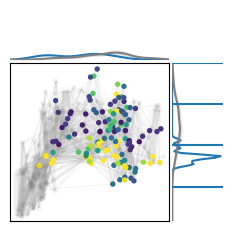

Approximate two sample Kolmogorov-Smirnov test
----------------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.549618

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-04

Details:
    number of observations:   [131,20]
    KS-statistic:              2.2894089316142034


In [50]:
let
    dict_feature = Dict()
    for (k,v) = hb_model_rel_enc

        dict_feature[k] = v["var"]
    end

    dict_x = Dict(dict_pos_v2_non_p)
    dict_y = Dict(dict_pos_z_non_p)

    dist_feature = vcat([v[1] for (k,v) = dict_feature]...)

    cutoff_feature = percentile(dist_feature, 85)
    println("cutoff: $cutoff_feature")
    
    list_all = Float64[]
    list_select = Float64[]
    for (neuron,y) = dict_y
        if !occursin(r"[A-Z]{2}\d", neuron) # check if not vc motor
            if haskey(dict_feature, neuron) 
                # neuron provided with or the class does not have dv & lr
                
                push!(list_all, y)
                v = dict_feature[neuron]
                if v > cutoff_feature
                    push!(list_select, y)
                end
            else
                class, dv, lr = get_neuron_class(neuron)
                
                class_dv = class
                if !(dv == "missing" || dv == "undefined")
                    class_dv = class * dv
                end
                
                if haskey(dict_feature, class_dv)
                    push!(list_all, y)
                    v = dict_feature[class_dv]
                    if v > cutoff_feature
                        push!(list_select, y)
                    end
                else
                    # println("$class missing in class dict")
                end
            end
        end # if not vc motor
    end
    
    
    bins = -1:((1.9+1)/3):1.9
    # range_of_interest = (0.05,0.975)  # Replace with your range of interest
    # range_bin_indices = 3 #findall(x -> range_of_interest[1] <= x <= range_of_interest[2], bins)[1:end-1]
    
    g = g_wh_lr
    
    vmin = 0.
    vmax = 0.4
    
    cmap = ColorMap("viridis")    
    
    #### plot
    f_select = x->x>cutoff_feature # function to select (for the blue line on the KDE)
    ax_main, ax_vertical, ax_horizontal = color_connectome_kde(g, list_muscle_wh_lr, dict_x, dict_y, dict_feature, f_select, vmin=vmin, vmax=vmax,
        n_control=100, cmap=cmap, node_size=15, figsize=(2.75, 2.75), xlim_scatter=(-0.017,0.025), ylim_scatter=(-1.8,1.9))

    for y = collect(bins)
        ax_vertical.axhline(y)
    end

    for range_bin_indices = 1:3
    
        # Calculate observed frequencies
        observed = fit(Histogram, list_all, bins).weights
        observed_special = fit(Histogram, list_select, bins).weights

        # Calculate the proportion of special points in the range of interest
        observed_proportion = sum(observed_special[range_bin_indices]) / sum(observed_special)

        # Calculate the expected proportion of special points in the range of interest
        expected_proportion = sum(observed[range_bin_indices]) / sum(observed)

        p_hat = observed_proportion
        p_pop = expected_proportion
        n = sum(observed_special)

        z_score = (p_hat - p_pop) / sqrt((p_pop * (1 - p_pop))/(n))
        p_value = 2 * (1 - cdf(Normal(), abs(z_score)))
        
        println("bin start: $(bins[range_bin_indices]) p_val: $p_value")
    end
    
    ApproximateTwoSampleKSTest(list_all, list_select)
end

### Variable

cutoff: 1.7331252875845649
neuron selected: 19 percentage: 18.45
random sampling among the recorded neurons. trial: 100
bin start: -0.017 p_val: 0.4530311300385188
bin start: -0.003 p_val: 0.01726008251578226
bin start: 0.011 p_val: 0.004478211302017643


┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/BgrVj/src/kolmogorov_smirnov.jl:167


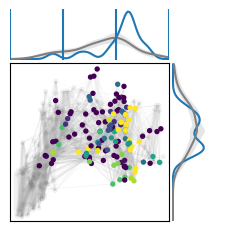

Approximate two sample Kolmogorov-Smirnov test
----------------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.43789

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           0.0015

Details:
    number of observations:   [131,22]
    KS-statistic:              1.9004946494881498


In [51]:
let
    dict_feature = hb_model_result["variability"]

    dict_x = Dict(dict_pos_v2_non_p)
    dict_y = Dict(dict_pos_z_non_p)

    #### cmap range
    dist_feature = vcat([v[1] for (k,v) = dict_feature]...)

    cutoff_feature = percentile(dist_feature, 85)
    println("cutoff: $cutoff_feature")
    
    list_all = Float64[]
    list_select = Float64[]
    for (neuron,x) = dict_x
        if !occursin(r"[A-Z]{2}\d", neuron) # check if not vc motor
            if haskey(dict_feature, neuron) 
                # neuron provided with or the class does not have dv & lr
                
                push!(list_all, x)
                v = dict_feature[neuron]
                if v > cutoff_feature
                    push!(list_select, x)
                end
            else
                class, dv, lr = get_neuron_class(neuron)
                
                class_dv = class
                if !(dv == "missing" || dv == "undefined")
                    class_dv = class * dv
                end
                
                if haskey(dict_feature, class_dv)
                    push!(list_all, x)
                    v = dict_feature[class_dv]
                    if v > cutoff_feature
                        push!(list_select, x)
                    end
                else
                    # println("$class missing in class dict")
                end
            end
        end # if not vc motor
    end
    
    
    
    bins = -0.017:((0.017+0.025)/3):0.025
    # range_of_interest = (0.05,0.975)  # Replace with your range of interest
    # range_bin_indices = 3 #findall(x -> range_of_interest[1] <= x <= range_of_interest[2], bins)[1:end-1]
    
    g = g_wh_lr
    
    vmin = 1.
    vmax = 1.9
    
    cmap = ColorMap("viridis")    
    
    #### plot
    f_select = x->x>cutoff_feature # function to select (for the blue line on the KDE)
    ax_main, ax_vertical, ax_horizontal = color_connectome_kde(g, list_muscle_wh_lr, dict_x, dict_y, dict_feature, f_select, vmin=vmin, vmax=vmax,
        n_control=100, cmap=cmap, node_size=15, figsize=(2.75, 2.75), xlim_scatter=(-0.017,0.025), ylim_scatter=(-1.8,1.9))

    for x = collect(bins)
        ax_horizontal.axvline(x)
    end

    for range_bin_indices = 1:3
    
        # Calculate observed frequencies
        observed = fit(Histogram, list_all, bins).weights
        observed_special = fit(Histogram, list_select, bins).weights
        
        # Calculate the proportion of special points in the range of interest
        observed_proportion = sum(observed_special[range_bin_indices]) / sum(observed_special)

        # Calculate the expected proportion of special points in the range of interest
        expected_proportion = sum(observed[range_bin_indices]) / sum(observed)

        p_hat = observed_proportion
        p_pop = expected_proportion
        n = sum(observed_special)

        z_score = (p_hat - p_pop) / sqrt((p_pop * (1 - p_pop))/(n))
        p_value = 2 * (1 - cdf(Normal(), abs(z_score)))
        
        println("bin start: $(bins[range_bin_indices]) p_val: $p_value")
    end
    
#     # hist(list_all)
#     # hist(list_select)
    ApproximateTwoSampleKSTest(list_all, list_select)
end

## Plot - connectome similarity analysis

In [34]:
function get_match_neuron(class_dv, list_g_node)
    list_neuron = String[]
    if class_dv ∈ list_g_node
        push!(list_neuron, class_dv)
    end

    if class_dv * "L" ∈ list_g_node
        push!(list_neuron, class_dv * "L")
    end
    
    if class_dv * "R" ∈ list_g_node
        push!(list_neuron, class_dv * "R")
    end
    
    list_neuron
end

get_match_neuron (generic function with 1 method)

In [35]:
function get_class_dv(neuron, list_class_dv)
    class, dv, lr = get_neuron_class(neuron)
    
    class_dv = class
    if dv ∈ ["D", "V"]
        class_dv *= dv        
    end

    if class_dv * lr ∈ list_class_dv
        class_dv *= lr
    end

    return class_dv
end

get_class_dv (generic function with 1 method)

In [38]:
let
    dict_feature = Dict()
    for (k,v) = hb_model_rel_enc
        enc_strength =  v[5] ^ 2
        dict_feature[k] = collect(enc_strength .* v[1:3])
    end
    
    list_no = Float64[]
    list_bi = Float64[]
    list_uni = Float64[]

    g = get_graph_witvliet(2, merge_lr=true, synapse_electrical=true)
    list_node = collect(g.nodes())
    
    list_k = collect(keys(dict_feature))
    @showprogress for n1 = list_node
        if !(ConnectomePlot.get_neuron_type_wv(n1) ∈ ["muscle", "unknown"])

            if haskey(dict_feature, n1)
                for n2 = list_node
                    if !(ConnectomePlot.get_neuron_type_wv(n2) ∈ ["muscle", "unknown"]) && n1 != n2
                        if haskey(dict_feature, n2)
                        
                            n_q_edge = g.has_edge(n1, n2) + g.has_edge(n2, n1)

                            dist_feature = euclidean(dict_feature[n1], dict_feature[n2])

                            if n_q_edge == 0
                                push!(list_no, dist_feature)
                            elseif n_q_edge == 1
                                push!(list_uni, dist_feature)
                            elseif n_q_edge == 2
                                push!(list_bi, dist_feature)
                            else
                                error("n_q_edge is $n_q_edge for $n1 and $n2")
                            end
                        end
                    end
                end
            end # haskey n1_class_dv
        end # check n1 
    end # for n1 list_node
    
    # hist(list_no, density=true)
    # hist(list_uni, density=true)
    # hist(list_bi, density=true)
    
    figure(figsize=(1.5,2))
    matplotlib.pyplot.violinplot([list_no, list_uni, list_bi])
    ylabel("encoding distance")
    xticks(1:3, ["none", "uni", "bi"])
    fix_plot()
    tight_layout()
    
    rg_ecdf = 0:0.05:1.75
    ecdf_no = ecdf(Float64.(list_no))
    ecdf_uni = ecdf(Float64.(list_uni))
    ecdf_bi = ecdf(Float64.(list_bi))
    
    figure(figsize=(2,1.5))
    plot(rg_ecdf, ecdf_no.(rg_ecdf), label="no (n=$(length(list_no)))")
    plot(rg_ecdf, ecdf_uni.(rg_ecdf), label="uni (n=$(length(list_uni)))")
    plot(rg_ecdf, ecdf_bi.(rg_ecdf), label="bi (n=$(length(list_bi)))")
    legend()
    xlim(0,1.)
    ylim(0,1.)
    xlabel("encoding distance")
    ylabel("ECDF")
    
    fix_plot()
    tight_layout()
    
    MannWhitneyUTest(list_bi, list_uni)
end

LoadError: KeyError: key 5 not found

### Input similarity - do input neurons have similar enc?

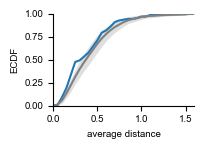

Approximate Mann-Whitney U test
-------------------------------
Population details:
    parameter of interest:   Location parameter (pseudomedian)
    value under h_0:         0
    point estimate:          0.0496994

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           0.0174

Details:
    number of observations in each group: [12000, 120]
    Mann-Whitney-U statistic:             8.10662e5
    rank sums:                            [7.27925e7, 6.60806e5]
    adjustment for ties:                  3666.0
    normal approximation (μ, σ):          (90661.5, 38138.2)


In [44]:
let
    g = get_graph_witvliet(2, merge_lr=true, synapse_electrical=true)
    list_node = collect(g.nodes())
    
    dict_feature = Dict()
    for (k,v) = hb_model_rel_enc
        enc_strength =  v[4]
        dict_feature[k] = collect(enc_strength .* v[1:3])
    end

    list_k = collect(keys(dict_feature))
    
    node_to_key = Dict{String,String}()
    
    dict_dist = Dict()
    for n1 = list_k, n2 = list_k
        dict_dist[(n1,n2)] = euclidean(dict_feature[n1], dict_feature[n2])
    end
    
#     for node = list_node
#         if !(ConnectomePlot.get_neuron_type_wv(node) ∈ ["muscle", "unknown"])
#             class_dv = get_class_dv(node, list_k)
#             if haskey(dict_feature, class_dv)
#                 node_to_key[node] = class_dv
#             end
#         end
#     end
        
    list_dist = Float64[]
    for node = list_node
        list_node_in = []
        for (node_in,_) = g.in_edges(node)
            if haskey(dict_feature, node_in)
                push!(list_node_in, node_in)
            end
        end

        dist_sum = 0.
        n_dist = 0
        for n1 = list_node_in, n2 = list_node_in
            if n1 != n2
                dist_sum += dict_dist[n1,n2]
                n_dist += 1
            end
        end

        dist_norm = dist_sum / n_dist
        if !isnan(dist_norm)
            push!(list_dist, dist_norm)
        end
    end
    
    n_repeat = 100
    list_dist_rand = []
    for i = 1:n_repeat
        list_dist_ = Float64[]
        dict_feature_rand = shuffle_dict_feature(dict_feature)
        dict_dist_rand = Dict()
        for n1 = list_k, n2 = list_k
            dict_dist_rand[(n1,n2)] = euclidean(dict_feature_rand[n1], dict_feature_rand[n2])
        end

        for node = list_node
            list_node_in = []
            for (node_in,_) = g.in_edges(node)
                if haskey(dict_feature_rand, node_in)
                    push!(list_node_in, node_in)
                end
            end

            dist_sum = 0.
            n_dist = 0
            for n1 = list_node_in, n2 = list_node_in
                if n1 != n2
                    dist_sum += dict_dist_rand[n1,n2]
                    n_dist += 1
                end
            end

            dist_norm = dist_sum / n_dist
            if !isnan(dist_norm)
                push!(list_dist_, dist_norm)
            end
        end
        
        push!(list_dist_rand, list_dist_)
    end

    # actual
    rg_ecdf = 0:0.05:1.6
    ecdf_real = ecdf(list_dist)
    
    # rand
    ecdf_rand = zeros(length(rg_ecdf), n_repeat)
    for i = 1:n_repeat
        ecdf_ = ecdf(list_dist_rand[i])
        ecdf_rand[:,i] = ecdf_.(rg_ecdf)
    end
    y1,y2,y3,u,s = aggregate_var(ecdf_rand)
    
    figure(figsize=(2,1.5))
    plot(rg_ecdf, ecdf_real.(rg_ecdf), color="C0")
    
    plot(rg_ecdf, y2, color="gray")
    fill_between(rg_ecdf, y1, y3, color="gray", alpha=0.25, linewidth=0)

    xlim(0,1.6)
    ylim(0,1)
    xlabel("average distance")
    ylabel("ECDF")
    
    fix_plot()
    tight_layout()
    
    mean(list_dist), mean(vcat(list_dist_rand...))
    
    
    MannWhitneyUTest(vcat(list_dist_rand...), list_dist)
end

### Pre-compute

In [36]:
list_cor_array = Matrix{Float64}[]
let
    @showprogress for (idx_uid, (uid, rg_t_use)) = enumerate(list_uid_use_all)
        match_dict = list_match_dict[idx_uid][2]
        data_dict = list_data_dict[idx_uid]
        trace_array = data_dict["trace_array"]
        
        rg_t = if rg_t_use == [1,2]
            1:1600
        elseif rg_t_use == [1]
            1:770
        else
            error("unknown rg_t_use")
        end

        n_neuron = size(trace_array,1)
        cor_array = zeros(n_neuron,n_neuron)
        for i = 1:n_neuron, j = 1:n_neuron
            cor_array[i,j] = (cor(trace_array[i,rg_t], trace_array[j,rg_t]))
        end
        push!(list_cor_array, cor_array)
    end
end;

dict_dist_cor = let
    n_c = length(list_class_dv_ordered)
    dict_dist = Dict()

    @time for (idx_uid, (uid, rg_t_use)) = enumerate(list_uid_use_all)
        match_dict = list_match_dict[idx_uid][2]
        cor_array = list_cor_array[idx_uid]
        
        rg_t = if rg_t_use == [1,2]
            1:1600
        elseif rg_t_use == [1]
            1:770
        else
            error("unknown rg_t_use")
        end
        
        for c1 = list_class_dv_ordered
            if haskey(match_dict, c1)
                list_neuron_c1 = [match[2] for match = match_dict[c1]]
                for c2 = list_class_dv_ordered
                    if haskey(match_dict, c2)
                        list_neuron_c2 = [match[2] for match = match_dict[c2]]
                    
                        list_cor = Float64[]
                        for neuron_c1 = list_neuron_c1
                            for neuron_c2 = list_neuron_c2
                                push!(list_cor, cor_array[neuron_c1, neuron_c2])
                            end
                        end
                        add_list_dict!(dict_dist, (c1, c2), mean(list_cor))
                    end # haskey c2
                end # for c2
            end # haskey c1
        end # for c1
    end # for idx_uid
    

    dict_dist_ = Dict{Tuple{String,String},Float64}()
    for (k,v) = dict_dist
        dict_dist_[k] = mean(v)
    end
    
    dict_dist_
end;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


  0.277935 seconds (2.59 M allocations: 85.562 MiB)


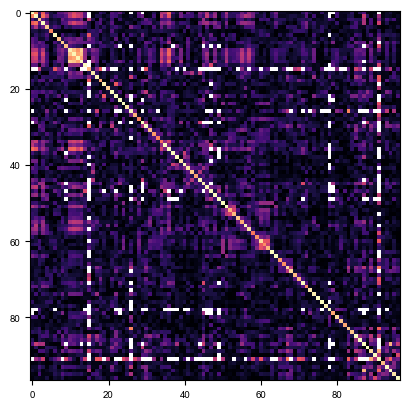

PyObject <matplotlib.image.AxesImage object at 0x7f041ffd84c0>

In [37]:
let
    n_class = length(list_class_dv_ordered)
    array_cor = zeros(n_class, n_class)
    for (i,c1) = enumerate(list_class_dv_ordered)
        for (j,c2) = enumerate(list_class_dv_ordered)
            if haskey(dict_dist_cor, (c1,c2))
                array_cor[i,j] = abs(dict_dist_cor[c1,c2])
            else
                array_cor[i,j] = NaN
            end
        end
    end
    
    imshow(array_cor, cmap="magma")
end

In [38]:
function get_rand_dict_dist_cor()
    n_c = length(list_class_dv_ordered)
    dict_dist = Dict()
    
    for (idx_uid, (uid, rg_t_use)) = enumerate(list_uid_use_all)
        match_dict = list_match_dict[idx_uid][2]
        cor_array = list_cor_array[idx_uid]
        match_list_neuron = Dict()
        for class = list_class_dv_ordered
            if haskey(match_dict, class)
                match_list_neuron[class] = map(x->x[2], match_dict[class])
            end
        end

        match_list_neuron = shuffle_dict_feature(match_list_neuron)
        
        rg_t = if rg_t_use == [1,2]
            1:1600
        elseif rg_t_use == [1]
            1:770
        else
            error("unknown rg_t_use")
        end
        
        for c1 = list_class_dv_ordered
            if haskey(match_dict, c1)
                for c2 = list_class_dv_ordered
                    if haskey(match_dict, c2)

                        list_neuron_c1 = match_list_neuron[c1]
                        list_neuron_c2 = match_list_neuron[c2]
                        
                        list_cor = Float64[]
                        for neuron_c1 = list_neuron_c1
                            for neuron_c2 = list_neuron_c2
                                push!(list_cor, cor_array[neuron_c1, neuron_c2])
                            end
                        end
                        
                        add_list_dict!(dict_dist, (c1, c2), mean(list_cor))
                    end # haskey c2
                end # for c2
            end # haskey c1
        end # for c1
    end # for idx_uid
    

    dict_dist_ = Dict{Tuple{String,String},Float64}()
    for (k,v) = dict_dist
        dict_dist_[k] = mean(v)
    end
    
    dict_dist_
end

get_rand_dict_dist_cor (generic function with 1 method)

### Do input neurons have similar encoding to the receiving neuron - mean

Progress: 100%|█████████████████████████████████████████| Time: 0:02:12


Approximate Mann-Whitney U test
-------------------------------
Population details:
    parameter of interest:   Location parameter (pseudomedian)
    value under h_0:         0
    point estimate:          -0.0632513

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-21

Details:
    number of observations in each group: [68000, 68]
    Mann-Whitney-U statistic:             754319.0
    rank sums:                            [2.31446e9, 2.19788e6]
    adjustment for ties:                  24.0
    normal approximation (μ, σ):          (-1.55768e6, 1.61954e5)



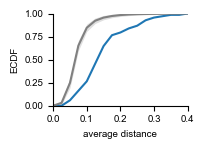

In [39]:
fig_list_dist_in, fig_list_dist_in_rand = let
    g = get_graph_witvliet(2, merge_lr=true, synapse_electrical=false, synapse_chemical=true)
    list_node = collect(g.nodes())
    
    dict_feature = Dict()
    for (k,v) = hb_model_rel_enc
        enc_strength =  v["var"]
        dict_feature[k] = collect(enc_strength .* [v["v"], v["θh"], v["P"]])
    end

    list_k = collect(keys(dict_feature))
    
    
    dict_dist = dict_dist_cor
            
    list_dist = Float64[]
    for node = list_node
        list_node_in = []
        
        if haskey(hb_model_rel_enc, node)
            for (node_in,_) = g.in_edges(node)
                if haskey(dict_feature, node_in)
                    push!(list_node_in, node_in)
                end
            end

            if length(list_node_in) > 0
                dist_sum = 0.
                n_dist = 0
                for node_in = list_node_in
                    if node_in != node
                        if haskey(dict_dist_cor, (node_in,node))
                            dist_sum += abs(dict_dist[node_in,node])
                            n_dist += 1
                        end
                    end
                end
                if n_dist > 0
                    dist_norm = dist_sum / n_dist
                    push!(list_dist, dist_norm)
                end
            end
        end
    end
    
    n_repeat = 1000
    list_dist_rand = Vector{Float64}[]
    @showprogress for i = 1:n_repeat
        list_dist_ = Float64[]
        dict_feature_rand = shuffle_dict_feature(dict_feature)
        dict_dist_rand = get_rand_dict_dist_cor()
        
        for node = list_node
            if haskey(hb_model_rel_enc, node)
                list_node_in = []            
                for (node_in,_) = g.in_edges(node)
                    if haskey(dict_feature_rand, node_in)
                        push!(list_node_in, node_in)
                    end
                end

                if length(list_node_in) > 0
                    dist_sum = 0.
                    n_dist = 0
                    for node_in = list_node_in
                        if node_in != node
                            if haskey(dict_dist_rand, (node_in, node))
                                dist_sum += abs(dict_dist_rand[node_in,node])
                                n_dist += 1
                            end
                        end
                    end
                    
                    if n_dist > 0
                        dist_norm = dist_sum / n_dist
                        push!(list_dist_, dist_norm)
                    end
                end
            end
        end
        
        push!(list_dist_rand, list_dist_)
    end
    
    # actual
    rg_ecdf = 0:0.025:0.4
    ecdf_real = ecdf(list_dist)
    
    # rand
    ecdf_rand = zeros(length(rg_ecdf), n_repeat)
    for i = 1:n_repeat
        ecdf_ = ecdf(list_dist_rand[i])
        ecdf_rand[:,i] = ecdf_.(rg_ecdf)
    end
    y1,y2,y3,u,s = aggregate_var(ecdf_rand)
    
    figure(figsize=(2,1.5))
    plot(rg_ecdf, ecdf_real.(rg_ecdf), color="C0")
    
    plot(rg_ecdf, y2, color="gray")
    fill_between(rg_ecdf, y1, y3, color="gray", alpha=0.25, linewidth=0)
    xlim(0,0.4)
    ylim(0,1)
    xlabel("average distance")
    ylabel("ECDF")
    
    fix_plot()
    tight_layout()
    # mean(list_dist), mean(vcat(list_dist_rand...))
    
    
    println(MannWhitneyUTest(vcat(list_dist_rand...), list_dist))
    
    list_dist, list_dist_rand
end;

### Do output neurons have similar encoding to the target neuron - mean

Progress: 100%|█████████████████████████████████████████| Time: 0:02:08


Approximate Mann-Whitney U test
-------------------------------
Population details:
    parameter of interest:   Location parameter (pseudomedian)
    value under h_0:         0
    point estimate:          -0.0641672

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-23

Details:
    number of observations in each group: [60000, 60]
    Mann-Whitney-U statistic:             425908.0
    rank sums:                            [1.80157e9, 2.06426e6]
    adjustment for ties:                  24.0
    normal approximation (μ, σ):          (-1.37409e6, 1.34232e5)



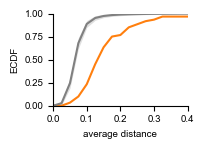

In [40]:
fig_list_dist_out, fig_list_dist_out_rand = let
    g = get_graph_witvliet(2, merge_lr=true, synapse_electrical=false, synapse_chemical=true)
    list_node = collect(g.nodes())
    
    dict_feature = Dict()
    for (k,v) = hb_model_rel_enc
        enc_strength =  v["var"]
        dict_feature[k] = collect(enc_strength .* [v["v"], v["θh"], v["P"]])
    end

    list_k = collect(keys(dict_feature))
    
    
    dict_dist = dict_dist_cor
            
    list_dist = Float64[]
    for node = list_node
        list_node_out = []
        
        if haskey(hb_model_rel_enc, node)
            for (_,node_out) = g.out_edges(node)
                if haskey(dict_feature, node_out)
                    push!(list_node_out, node_out)
                end
            end

            if length(list_node_out) > 0
                dist_sum = 0.
                n_dist = 0
                for node_out = list_node_out
                    if node_out != node && haskey(dict_dist, (node,node_out))
                        dist_sum += abs(dict_dist[node,node_out])
                        n_dist += 1
                    end
                end
                
                if n_dist > 0
                    dist_norm = dist_sum / n_dist
                    push!(list_dist, dist_norm)
                end
            end
        end
    end
    
    n_repeat = 1000
    list_dist_rand = Vector{Float64}[]
    @showprogress for i = 1:n_repeat
        list_dist_ = Float64[]
        dict_feature_rand = shuffle_dict_feature(dict_feature)
        dict_dist_rand = get_rand_dict_dist_cor()
        
        for node = list_node
            if haskey(hb_model_rel_enc, node)
                list_node_out = []            
                for (_,node_out) = g.out_edges(node)
                    if haskey(dict_feature_rand, node_out)
                        push!(list_node_out, node_out)
                    end
                end

                if length(list_node_out) > 0
                    dist_sum = 0.
                    n_dist = 0
                    for node_out = list_node_out
                        if node_out != node
                            if haskey(dict_dist_rand, (node,node_out))
                                dist_sum += abs(dict_dist_rand[node,node_out])
                                n_dist += 1
                            end
                        end
                    end
                    if n_dist > 0
                        dist_norm = dist_sum / n_dist
                        push!(list_dist_, dist_norm)
                    end
                end
            end
        end
        
        push!(list_dist_rand, list_dist_)
    end
    
    # actual
    rg_ecdf = 0:0.025:0.4
    ecdf_real = ecdf(list_dist)
    
    # rand
    ecdf_rand = zeros(length(rg_ecdf), n_repeat)
    for i = 1:n_repeat
        ecdf_ = ecdf(list_dist_rand[i])
        ecdf_rand[:,i] = ecdf_.(rg_ecdf)
    end
    y1,y2,y3,u,s = aggregate_var(ecdf_rand)
    
    figure(figsize=(2,1.5))
    plot(rg_ecdf, ecdf_real.(rg_ecdf), color="C1")
    
    plot(rg_ecdf, y2, color="gray")
    fill_between(rg_ecdf, y1, y3, color="gray", alpha=0.25, linewidth=0)
    xlim(0,0.4)
    ylim(0,1)
    xlabel("average distance")
    ylabel("ECDF")
    
    fix_plot()
    tight_layout()
    # mean(list_dist), mean(vcat(list_dist_rand...))
    
    
    println(MannWhitneyUTest(vcat(list_dist_rand...), list_dist))
    
    list_dist, list_dist_rand
end;

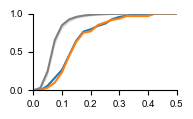

In [44]:
let
    list_in = fig_list_dist_in
    list_out = fig_list_dist_out
    list_rand = fig_list_dist_in_rand
    
    # actual
    rg_ecdf = 0:0.025:0.5
    ecdf_in = ecdf(list_in)
    ecdf_out = ecdf(list_out)
    
    # rand
    n_repeat = 1000
    ecdf_rand = zeros(length(rg_ecdf), n_repeat)
    for i = 1:n_repeat
        ecdf_ = ecdf(list_rand[i])
        ecdf_rand[:,i] = ecdf_.(rg_ecdf)
    end
    y1,y2,y3,u,s = aggregate_var(ecdf_rand)
    
    figure(figsize=(2,1.2))
    plot(rg_ecdf, ecdf_in.(rg_ecdf), color="C0")
    plot(rg_ecdf, ecdf_out.(rg_ecdf), color="C1")
    
    plot(rg_ecdf, y2, color="gray")
    fill_between(rg_ecdf, y1, y3, color="gray", alpha=0.25, linewidth=0)
    xlim(0,0.5)
    ylim(0,1)
    xticks(0:0.1:0.5)
    # xlabel("Mean abs cor")
    # ylabel("ECDF")
    
    fix_plot()
    tight_layout()

    savefig(joinpath(path_fig_root, "connectome_in_and_out.pdf"))
end

### Output encoding similarity vs encoding similarity

In [37]:
function get_out_nodes(g, node::String, dict_check::Dict)
    list_out_of = String[]
    for (_,node_out) = g.out_edges(node)
        if haskey(dict_check, node_out)
            push!(list_out_of, node_out)
        end
    end
    
    list_out_of
end

function get_in_nodes(g, node::String, dict_check::Dict)
    list_in_of = String[]
    for (node_in,_) = g.in_edges(node)
        if haskey(dict_check, node_in)
            push!(list_in_of, node_in)
        end
    end
    
    list_in_of
end

get_in_nodes (generic function with 1 method)

In [38]:
let
    g = get_graph_witvliet(2, merge_lr=true, synapse_electrical=true)
    list_node = collect(g.nodes())
    
    dict_feature = Dict()
    for (k,v) = hb_model_rel_enc
        enc_strength =  v[4]
        dict_feature[k] = collect(enc_strength .* v[1:3])
    end

    list_k = collect(keys(dict_feature))
    
    
    dict_dist = Dict()
    for n1 = list_k, n2 = list_k
        dict_dist[(n1,n2)] = euclidean(dict_feature[n1], dict_feature[n2])
    end


    list_dist = Tuple{Float64,Float64}[]
    
    for n1 = list_k
        if haskey(dict_feature, n1)
            list_out_of_n1 = get_out_nodes(g, n1, dict_feature)

            for n2 = list_k
                if haskey(dict_feature, n2)
                    sum_dist = 0.
                    n_pair = 0
                    list_out_of_n2 = get_out_nodes(g, n2, dict_feature)
                    
                    for out1 = list_out_of_n1, out2 = list_out_of_n2
                        sum_dist += euclidean(dict_feature[out1], dict_feature[out2])
                        n_pair += 1
                    end
                    
                    norm_dist = sum_dist / n_pair
                    
                    enc_dist = euclidean(dict_feature[n1], dict_feature[n2])
                    # encoding distance
                    push!(list_dist, (enc_dist, norm_dist))
                end
            end
        end
    end
    figure(figsize=(3,3))
    scatter(map(x->x[1], list_dist), map(x->x[2], list_dist), s=5)
    xlabel("encoding distance")
    ylabel("output distance")
    
    
    data = DataFrame(x=map(x->x[1], list_dist), y=map(x->x[2], list_dist))
    model = lm(@formula(y ~ x), data)
    r2(model)
end

LoadError: KeyError: key 4 not found

In [39]:
let
    g = get_graph_witvliet(2, merge_lr=true, synapse_electrical=true)
    list_node = collect(g.nodes())
    
    dict_feature = Dict()
    for (k,v) = hb_model_rel_enc
        enc_strength =  v[4]
        dict_feature[k] = collect(enc_strength .* v[1:3])
    end

    list_k = collect(keys(dict_feature))
    
    
    dict_dist = Dict()
    for n1 = list_k, n2 = list_k
        dict_dist[(n1,n2)] = euclidean(dict_feature[n1], dict_feature[n2])
    end


    list_dist = Tuple{Float64,Float64}[]
    
    for n1 = list_k
        if haskey(dict_feature, n1)
            list_out_of_n1 = get_out_nodes(g, n1, dict_feature)

            for n2 = list_k
                if haskey(dict_feature, n2)
                    list_out_of_n2 = get_out_nodes(g, n2, dict_feature)
                    
                    n_out_of_n1 = length(list_out_of_n1)
                    n_out_of_n2 = length(list_out_of_n2)
                    
                    if n_out_of_n1 > 0 && n_out_of_n2 > 0
                        out1_freature = zeros(n_out_of_n1, 3)
                        out2_freature = zeros(n_out_of_n2, 3)

                        for (i,out1) = enumerate(list_out_of_n1)
                            out1_freature[i,:] = dict_feature[out1]
                        end
                        for (i,out2) = enumerate(list_out_of_n2)
                            out2_freature[i,:] = dict_feature[out2]
                        end

                        u_out1 = meanprj(out1_freature, dims=1)
                        u_out2 = meanprj(out2_freature, dims=1)
                        
                        out_dist = euclidean(u_out1, u_out2)
                        enc_dist = euclidean(dict_feature[n1], dict_feature[n2])
                        push!(list_dist, (enc_dist, out_dist))
                    end
                end
            end
        end
    end
   
    figure(figsize=(3,3))
    scatter(map(x->x[1], list_dist), map(x->x[2], list_dist), s=5)
    xlabel("encoding distance")
    ylabel("output distance")
    
    data = DataFrame(x=map(x->x[1], list_dist), y=map(x->x[2], list_dist))
    model = lm(@formula(y ~ x), data)
    r2(model)
end

LoadError: KeyError: key 4 not found

## Plot - connectivity vs similarity

In [40]:
function get_class_dv(neuron, list_class_dv)
    class, dv, lr = get_neuron_class(neuron)
    
    class_dv = class
    if dv ∈ ["D", "V"]
        class_dv *= dv        
    end

    if class_dv * lr ∈ list_class_dv
        class_dv *= lr
    end

    return class_dv
end

get_class_dv (generic function with 1 method)

In [41]:
list_dist_no, list_dist_uni, list_dist_bi_c = let
    list_no = Float64[]
    list_uni = Float64[]
    list_bi_c = Float64[]

    g = get_graph_witvliet(2,merge_lr=false, synapse_chemical=true, synapse_electrical=false) #deepcopy(g_wv_lr)
    list_node = collect(g.nodes())
    
    dict_feature = Dict()
    for (k,v) = hb_model_rel_enc
        enc_strength =  v["var"]
        dict_feature[k] = collect(enc_strength .* [v["v"], v["θh"], v["P"]])
    end
    
    list_k = collect(keys(dict_feature))
    @showprogress for n1 = list_node
        if !(ConnectomePlot.get_neuron_type_wv(n1) ∈ ["muscle", "unknown"])
            n1_class_dv = get_class_dv(n1, list_k)

            if haskey(dict_feature, n1_class_dv)
                for n2 = list_node
                    if !(ConnectomePlot.get_neuron_type_wv(n2) ∈ ["muscle", "unknown"]) && n1 != n2
                        n2_class_dv = get_class_dv(n2, list_k)
                        if haskey(dict_feature, n2_class_dv)
                        
                            n_q_edge = g.has_edge(n1, n2) + g.has_edge(n2, n1)

                            if haskey(dict_dist_cor, (n1_class_dv,n2_class_dv))
                                dist_feature = abs(dict_dist_cor[n1_class_dv,n2_class_dv])

                                if n_q_edge == 0
                                    push!(list_no, dist_feature)
                                elseif n_q_edge == 1
                                    if n1[1:end-1] != n2[1:end-1]
                                        push!(list_uni, dist_feature)
                                    end
                                elseif n_q_edge == 2
                                    if n1[1:end-1] != n2[1:end-1]
                                        push!(list_bi_c, dist_feature)
                                    end
                                else
                                    error("n_q_edge is $n_q_edge for $n1 and $n2")
                                end
                            end
                        end
                    end
                end
            end # haskey n1_class_dv
        end # check n1 
    end # for n1 list_node    
    
    list_no, list_uni, list_bi_c
end;

list_dist_bi_e, list_bi_e_pair = let
    list_bi = Float64[]
    list_bi_e_pair = []
    
    g = get_graph_witvliet(2,merge_lr=false, synapse_chemical=false, synapse_electrical=true)
    list_node = collect(g.nodes())
    
    dict_feature = Dict()
    for (k,v) = hb_model_rel_enc
        enc_strength =  v["var"]
        dict_feature[k] = collect(enc_strength .* [v["v"], v["θh"], v["P"]])
    end
    
    list_k = collect(keys(dict_feature))
    @showprogress for n1 = list_node
        if !(ConnectomePlot.get_neuron_type_wv(n1) ∈ ["muscle", "unknown"])
            n1_class_dv = get_class_dv(n1, list_k)

            if haskey(dict_feature, n1_class_dv)
                for n2 = list_node
                    if !(ConnectomePlot.get_neuron_type_wv(n2) ∈ ["muscle", "unknown"]) && n1 != n2
                        n2_class_dv = get_class_dv(n2, list_k)
                        if haskey(dict_feature, n2_class_dv)
                        
                            n_q_edge = g.has_edge(n1, n2) + g.has_edge(n2, n1)

                            if haskey(dict_dist_cor, (n1_class_dv,n2_class_dv))
                                dist_feature = abs(dict_dist_cor[n1_class_dv,n2_class_dv])

                                if n_q_edge == 0
                                    # push!(list_no, dist_feature)
                                elseif n_q_edge == 1 
                                    # push!(list_uni, dist_feature)
                                elseif n_q_edge == 2
                                    if n1[1:end-1] != n2[1:end-1]
                                        push!(list_bi, dist_feature)
                                        push!(list_bi_e_pair, (dist_feature, n1, n2))
                                    end
                                else
                                    error("n_q_edge is $n_q_edge for $n1 and $n2")
                                end
                            end
                        end
                    end
                end
            end # haskey n1_class_dv
        end # check n1 
    end # for n1 list_node    
    
    list_bi, list_bi_e_pair
end;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


In [42]:
sort(by=x->x[1], list_bi_e_pair, rev=true)[1:20]

20-element Vector{Any}:
 (0.905527174022259, "AVAL", "RIMR")
 (0.905527174022259, "AVAR", "RIML")
 (0.905527174022259, "AVAR", "RIMR")
 (0.905527174022259, "RIML", "AVAR")
 (0.905527174022259, "RIMR", "AVAL")
 (0.905527174022259, "RIMR", "AVAR")
 (0.878398710976178, "AVEL", "RIML")
 (0.878398710976178, "AVEL", "RIMR")
 (0.878398710976178, "AVER", "RIML")
 (0.878398710976178, "AVER", "RIMR")
 (0.878398710976178, "RIML", "AVEL")
 (0.878398710976178, "RIML", "AVER")
 (0.878398710976178, "RIMR", "AVEL")
 (0.878398710976178, "RIMR", "AVER")
 (0.8658961167982279, "AVAL", "AVEL")
 (0.8658961167982279, "AVEL", "AVAL")
 (0.5258498851058582, "RIBL", "SIBVL")
 (0.5258498851058582, "RIBR", "SIBVL")
 (0.5258498851058582, "RIBR", "SIBVR")
 (0.5258498851058582, "SIBVL", "RIBL")

no vs uni
Approximate Mann-Whitney U test
-------------------------------
Population details:
    parameter of interest:   Location parameter (pseudomedian)
    value under h_0:         0
    point estimate:          -0.0176743

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-09

Details:
    number of observations in each group: [18536, 1240]
    Mann-Whitney-U statistic:             1.02865e7
    rank sums:                            [1.82879e8, 1.26759e7]
    adjustment for ties:                  968910.0
    normal approximation (μ, σ):          (-1.20586e6, 1.94629e5)


no vs bi c
Approximate Mann-Whitney U test
-------------------------------
Population details:
    parameter of interest:   Location parameter (pseudomedian)
    value under h_0:         0
    point estimate:          -0.0183647

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           0.0402

Details:
    number of observations in eac

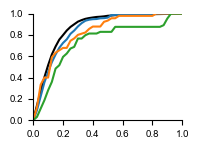

In [44]:
let    
    rg_ecdf = 0:0.025:1
    ecdf_no = ecdf(Float64.(list_dist_no))
    ecdf_uni = ecdf(Float64.(list_dist_uni))
    ecdf_bi_c = ecdf(Float64.(list_dist_bi_c))
    ecdf_bi_e = ecdf(Float64.(list_dist_bi_e))

    figure(figsize=(2,1.5))
    plot(rg_ecdf, ecdf_no.(rg_ecdf), color="k")
    plot(rg_ecdf, ecdf_uni.(rg_ecdf))
    plot(rg_ecdf, ecdf_bi_c.(rg_ecdf))
    plot(rg_ecdf, ecdf_bi_e.(rg_ecdf))

    xlim(0,1)
    ylim(0,1.)
    xticks(0:0.2:1)
    # xlabel("Mean abs cor")
    # ylabel("ECDF")
    
    fix_plot()
    tight_layout()
    savefig(joinpath(path_fig_root, "connectome_connectivity_and_cor.pdf"))
    
    println("no vs uni")
    MannWhitneyUTest(list_dist_no, list_dist_uni) |>println
    println()
    println("no vs bi c")
    MannWhitneyUTest(list_dist_no, list_dist_bi_c) |>println

    println()
    println("bi c vs bi e")
    MannWhitneyUTest(list_dist_bi_c, list_dist_bi_e) |>println

end